# MLOps from an Opensource point of view

In [1]:
# Regular Python Imports for work
import pandas as pd
import pycaret as pc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter 
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data 
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_history_alive


In [2]:
# checking directory
!pwd

/Users/0ill/Documents/mlops_works/notebooks


## Data Access Opensource

### Local Machine

In [3]:
def optimize_data_types(data):
    """Optimize data types to reduce memory usage."""
    for column in data.columns:
        column_type = data[column].dtype

        # Check for numeric types
        if pd.api.types.is_numeric_dtype(column_type):
            if pd.api.types.is_integer_dtype(column_type):
                # Downcast integer types
                data[column] = pd.to_numeric(data[column], downcast='integer')
            elif pd.api.types.is_float_dtype(column_type):
                # Downcast float types
                data[column] = pd.to_numeric(data[column], downcast='float')

        # Check for categorical types
        elif pd.api.types.is_object_dtype(column_type):
            unique_values = data[column].nunique()
            total_values = data[column].size
            if unique_values / total_values < 0.5:  # 50% unique values threshold
                # Convert to category if there are few unique values
                data[column] = data[column].astype('category')
            else:
                # Convert to the new string type for better performance
                data[column] = data[column].astype('string')

        # Check for boolean types
        elif pd.api.types.is_bool_dtype(column_type):
            # Convert booleans to a more memory-efficient representation if needed
            data[column] = data[column].astype('bool')

    return data


In [4]:
start_data = pd.read_excel('../data/Adidas.xlsx',header=4,).drop(['Unnamed: 0'], axis=1)
start_data.tail()

Retailer  Retailer ID Invoice Date     Region          State  \
9643  Foot Locker      1185732   2021-01-24  Northeast  New Hampshire   
9644  Foot Locker      1185732   2021-01-24  Northeast  New Hampshire   
9645  Foot Locker      1185732   2021-02-22  Northeast  New Hampshire   
9646  Foot Locker      1185732   2021-02-22  Northeast  New Hampshire   
9647  Foot Locker      1185732   2021-02-22  Northeast  New Hampshire   

            City                  Product  Price per Unit  Units Sold  \
9643  Manchester            Men's Apparel            50.0          64   
9644  Manchester          Women's Apparel            41.0         105   
9645  Manchester    Men's Street Footwear            41.0         184   
9646  Manchester  Men's Athletic Footwear            42.0          70   
9647  Manchester  Women's Street Footwear            29.0          83   

      Total Sales  Operating Profit  Operating Margin Sales Method  
9643       3200.0            896.00              0.28       Outlet  
9644       4305.0           1377.60              0.32       Outlet  
9645       7544.0           2791.28              0.37       Outlet  
9646       2940.0           1234.80              0.42       Outlet  
9647       2407.0            649.89              0.27       Outlet

In [5]:
# Check memory usage before optimization
print("Memory usage before optimization:")
print(start_data.info(memory_usage='deep'))

# Optimize data types
data_optimized = optimize_data_types(start_data)
start_data = data_optimized.copy()
del data_optimized

# Check memory usage after optimization
print("\nMemory usage after optimization:")
print(start_data.info(memory_usage='deep'))

Memory usage before optimization:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9648 entries, 0 to 9647
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Retailer          9648 non-null   object        
 1   Retailer ID       9648 non-null   int64         
 2   Invoice Date      9648 non-null   datetime64[ns]
 3   Region            9648 non-null   object        
 4   State             9648 non-null   object        
 5   City              9648 non-null   object        
 6   Product           9648 non-null   object        
 7   Price per Unit    9648 non-null   float64       
 8   Units Sold        9648 non-null   int64         
 9   Total Sales       9648 non-null   float64       
 10  Operating Profit  9648 non-null   float64       
 11  Operating Margin  9648 non-null   float64       
 12  Sales Method      9648 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(2), 

## Data Validation

In [6]:
start_data['Invoice Date'].max()

Timestamp('2021-12-31 00:00:00')

Advanced

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [8]:
def check_data_types(df):
    """Check and print data types of each column."""
    data_types = df.dtypes
    print("Data Types:\n", data_types)
    return data_types

def check_missing_values(df):
    """Check for missing values in the dataframe."""
    missing = df.isnull().sum()
    if missing.any():
        print("Missing Values:\n", missing[missing > 0])
        print("Result: Bad (Presence of missing values)")
    else:
        print("No missing values found.")
        print("Result: Good")

def check_duplicate_rows(df):
    """Check for duplicate rows in the dataframe."""
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"Duplicate Rows: {duplicates}")
        print("Result: Bad (Presence of duplicate rows)")
    else:
        print("No duplicate rows found.")
        print("Result: Good")

def check_statistical_summary(df):
    """Print the statistical summary of numerical columns."""
    if not df.empty:
        print("Statistical Summary:\n", df.describe())
    else:
        print("No data available for statistical summary.")
        
def calculate_bounds(df, column):
    """Calculate the lower and upper bounds using IQR for a numeric column."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

def detect_outliers(df,column):
    """Check for outliers in a specific column and visualize them."""
    lower_bound, upper_bound = calculate_bounds(df, column)

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    non_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    plt.figure(figsize=(20, 15))

    # Box Plot
    plt.subplot(3, 2, 1)
    sns.boxplot(x=df[column])
    plt.scatter(outliers[column], [0] * len(outliers), color='red', label='Outliers')
    plt.title(f'Boxplot for {column}')
    plt.legend()

    # Violin Plot
    plt.subplot(3, 2, 2)
    sns.violinplot(x=df[column])
    plt.scatter(outliers[column], [0] * len(outliers), color='red', label='Outliers')
    plt.title(f'Violin Plot for {column}')
    plt.legend()

    # Histogram with Density Plot
    plt.subplot(3, 2, 3)
    sns.histplot(df[column], bins=30, kde=True)
    plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
    plt.axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')
    plt.scatter(outliers[column], [0] * len(outliers), color='red', label='Outliers', s=50)
    plt.title(f'Histogram with Density for {column}')
    plt.legend()

    # Scatter Plot
    plt.subplot(3, 2, 4)
    plt.scatter(df.index, df[column], alpha=0.5, label='Good Data', color='blue')
    plt.scatter(outliers.index, outliers[column], color='red', label='Outliers', s=50)
    plt.axhline(y=df[column].mean(), color='green', linestyle='--', label='Mean')
    plt.axhline(y=df[column].median(), color='orange', linestyle='--', label='Median')
    plt.title(f'Scatter Plot for {column}')
    plt.legend()

    # Z-Score Method
    z_scores = (df[column] - df[column].mean()) / df[column].std()
    plt.subplot(3, 2, 5)
    sns.histplot(z_scores, bins=30, kde=True)
    plt.axvline(-3, color='red', linestyle='--', label='Outlier Bound (-3)')
    plt.axvline(3, color='red', linestyle='--', label='Outlier Bound (3)')
    plt.title(f'Z-Score Distribution for {column}')
    plt.legend()

    # IQR Method Distribution
    plt.subplot(3, 2, 6)
    sns.histplot(df[column], bins=30, kde=True)
    plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
    plt.axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')
    plt.scatter(outliers[column], [0] * len(outliers), color='red', label='Outliers', s=50)
    plt.title(f'Value Distribution with IQR Bounds for {column}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    if not outliers.empty:
        print(f"Outliers detected in column {column}:\n{outliers}")
        print("Result: Bad (Presence of outliers)")
    else:
        print("No outliers detected.")
        print("Result: Good (No outliers)")

    
    z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
    outliers = (z_scores > 3).sum(axis=0)
    
    for col, count in zip(df.select_dtypes(include=[np.number]).columns, outliers):
        if count > 0:
            print(f'Outliers in {col}: {count} (Result: Bad)')
        else:
            print(f'No outliers in {col} (Result: Good)')

def plot_distribution(df):
    """Plot the distribution of numerical features."""
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        if df[col].empty:
            print(f"No data available to plot distribution for {col}.")
            continue
        
        plt.figure(figsize=(10, 5))
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid()
        plt.show()

def plot_feature_correlation(df):
    """Plot the correlation matrix."""
    plt.figure(figsize=(12, 8))
    correlation = df.corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', square=True)
    plt.title('Feature Correlation Matrix')
    plt.show()

def check_skewness_kurtosis(df):
    """Check skewness and kurtosis for numerical columns."""
    if df.empty:
        print("No data available for skewness and kurtosis checks.")
        return
    
    skewness = df.skew()
    kurtosis = df.kurtosis()
    
    print("Skewness:\n", skewness)
    print("\nKurtosis:\n", kurtosis)
    
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].empty:
            print(f"No data available for column: {col}.")
            continue
        
        skew_status = "Normal" if -0.5 < skewness[col] < 0.5 else "Skewed"
        kurtosis_status = "Normal" if kurtosis[col] < 3 else "Heavy-tailed"
        print(f"{col} - Skewness: {skewness[col]:.4f} ({skew_status}), Kurtosis: {kurtosis[col]:.4f} ({kurtosis_status})")
        
def check_categorical_distribution(df):
    """Check distribution of categorical variables."""
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        counts = df[col].value_counts()
        if counts.empty:
            print(f"No data available for categorical distribution of {col}.")
            continue
        
        plt.figure(figsize=(10, 5))
        sns.barplot(x=counts.index, y=counts.values)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.grid()
        plt.show()
        print(f"\nCounts for {col}:\n", counts)


def check_time_series(df, time_column):
    """Check for time series data consistency."""
    if df.empty or time_column not in df.columns:
        print("No data available for time series check or column not found.")
        return
    
    # Convert the time column to datetime
    df[time_column] = pd.to_datetime(df[time_column])
    
    # Sort the DataFrame by the time column
    df.sort_values(by=time_column, inplace=True)
    
    plt.figure(figsize=(10, 5))
    
    # Iterate over each column except the time column
    for col in df.columns.difference([time_column]):
        plt.plot(df[time_column], df[col], label=col)
    
        plt.title('Time Series Data Overview')
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.grid()
        plt.legend()  # Add a legend to identify the lines
        plt.show()

def calculate_vif(df):
    """Calculate Variance Inflation Factor for multicollinearity."""
    vif = pd.DataFrame()
    vif["Feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    
    print("Variance Inflation Factor:\n", vif)

In [9]:
def run_type_specific_checks(df):
    """Run checks based on column types."""
    for col, dtype in zip(df.columns, df.dtypes):
        print(f"\nChecking column: {col} (Type: {dtype})")
        
        if pd.api.types.is_numeric_dtype(dtype):
            print("Running checks for numerical data...")
            check_statistical_summary(df[[col]])
            detect_outliers(df[[col]],col)
            plot_distribution(df[[col]])
            check_skewness_kurtosis(df[[col]])
            #calculate_vif(df[[col]])
        
        elif pd.api.types.is_object_dtype(dtype):
            print("Running checks for categorical data...")
            check_categorical_distribution(df[[col]])
        
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            print("Running checks for datetime data...")
            check_time_series(df, col)
        
        else:
            print(f"No specific checks for type: {dtype}")


Checking column: Retailer (Type: category)
No specific checks for type: category

Checking column: Retailer ID (Type: int32)
Running checks for numerical data...
Statistical Summary:
         Retailer ID
count  9.648000e+03
mean   1.173850e+06
std    2.636038e+04
min    1.128299e+06
25%    1.185732e+06
50%    1.185732e+06
75%    1.185732e+06
max    1.197831e+06


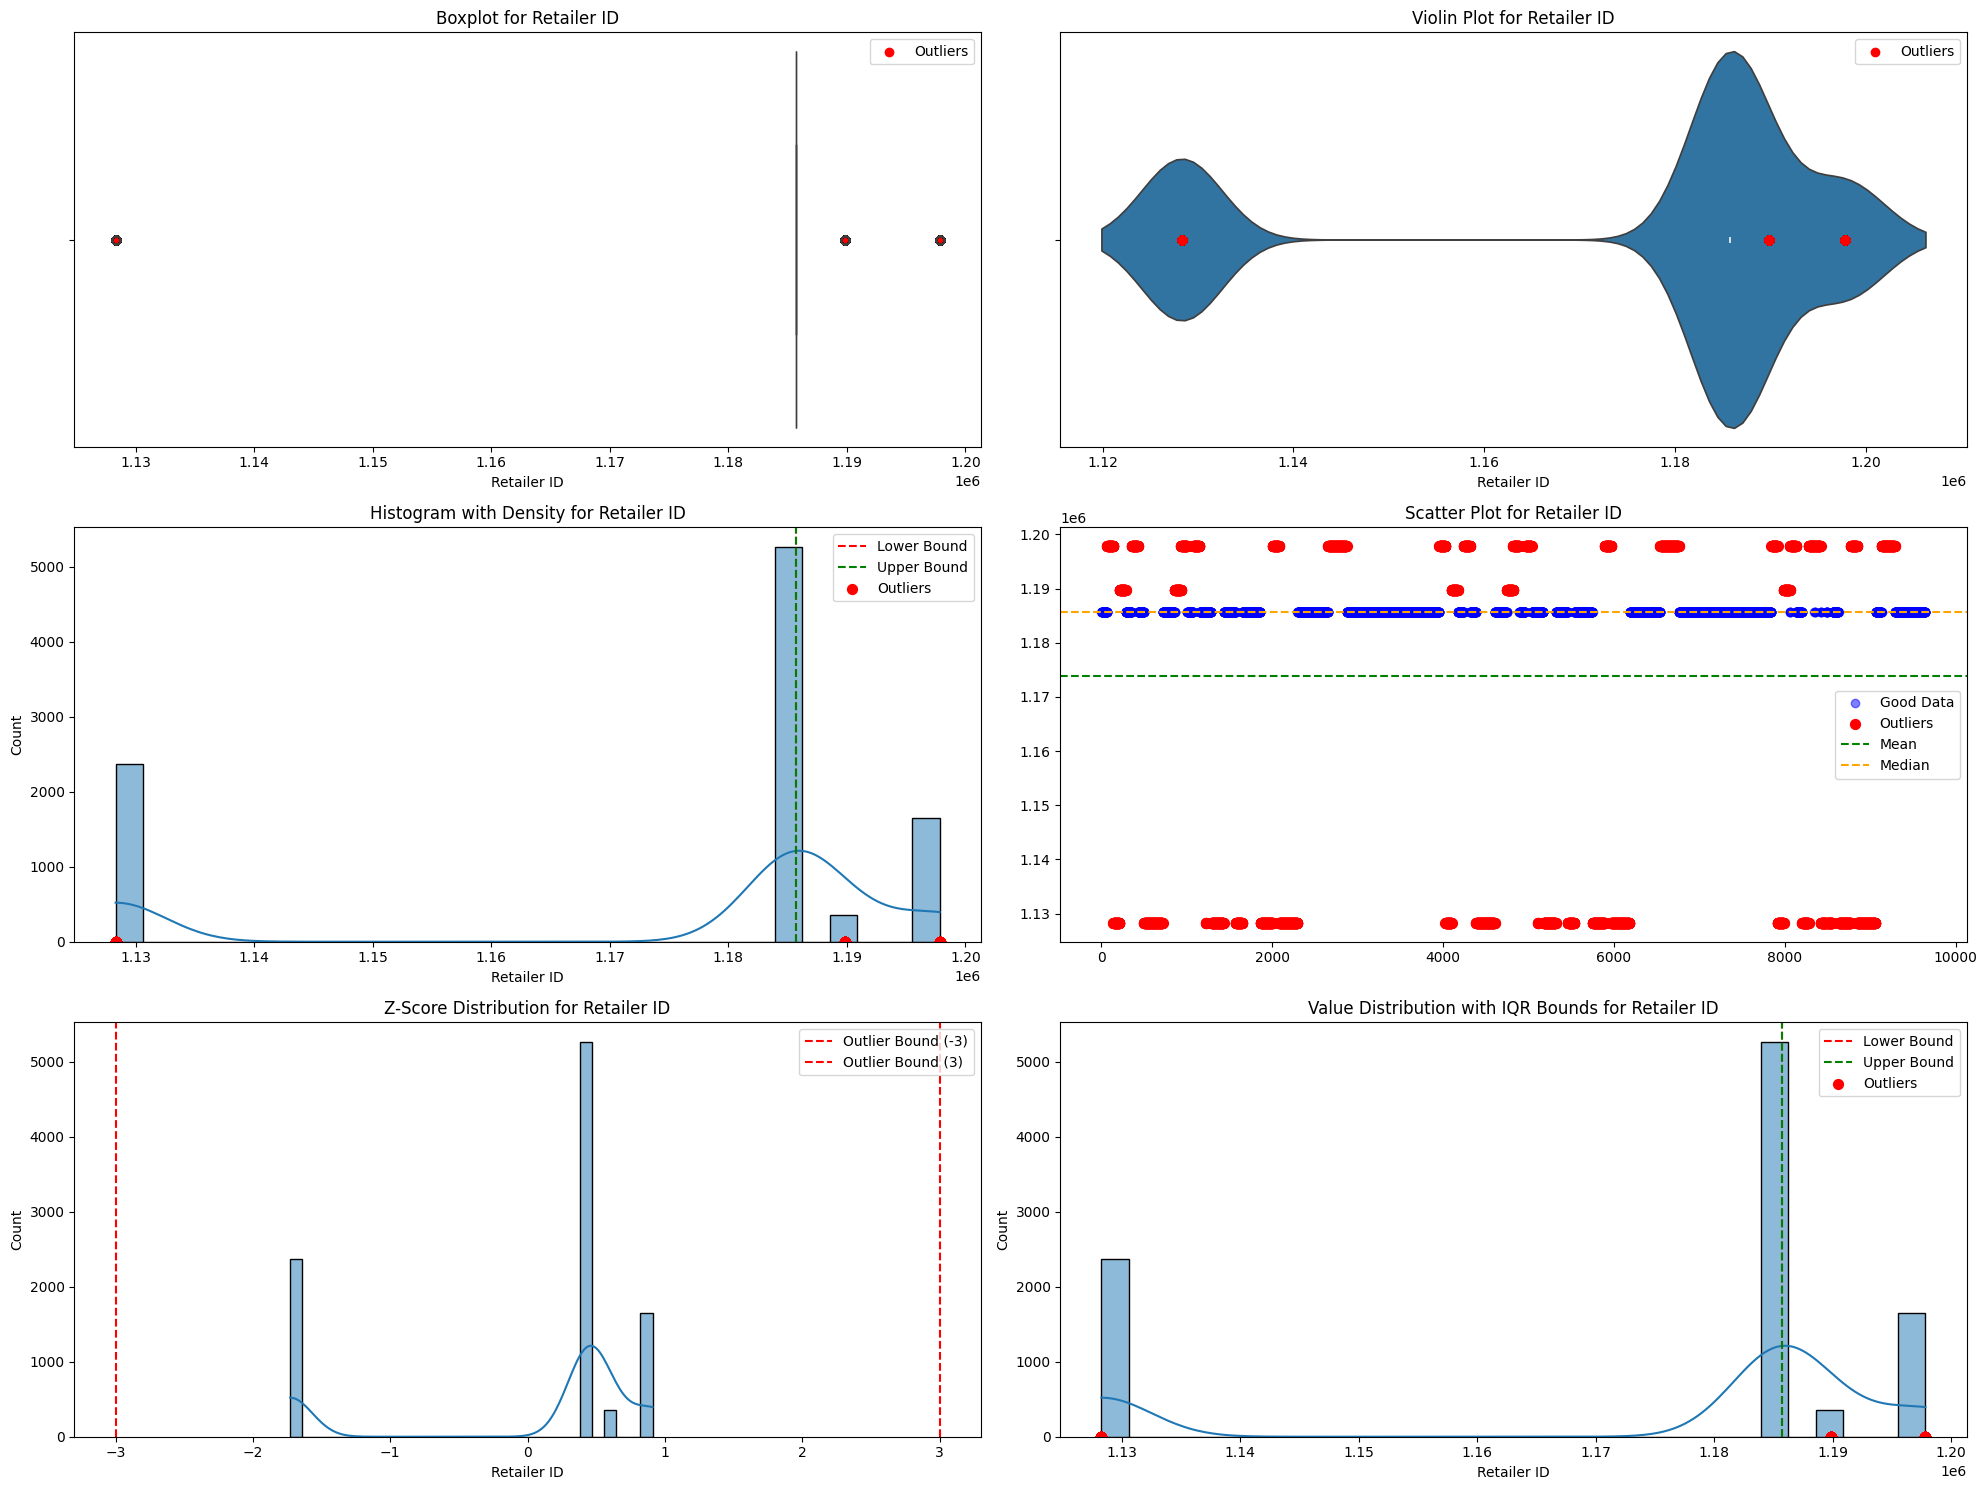

Outliers detected in column Retailer ID:
      Retailer ID
4388      1128299
8204      1128299
500       1128299
8205      1128299
501       1128299
...           ...
2222      1128299
6105      1128299
6106      1128299
2217      1128299
6108      1128299

[4383 rows x 1 columns]
Result: Bad (Presence of outliers)
No outliers in Retailer ID (Result: Good)


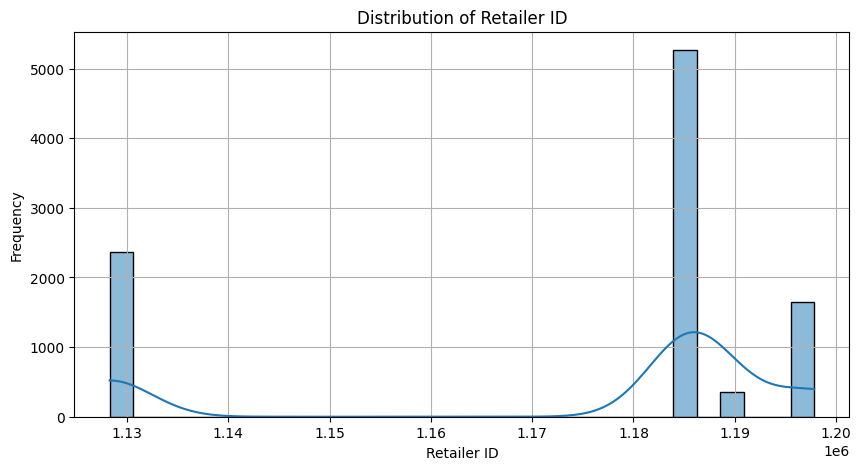

Skewness:
 Retailer ID   -1.080517
dtype: float64

Kurtosis:
 Retailer ID   -0.664096
dtype: float64
Retailer ID - Skewness: -1.0805 (Skewed), Kurtosis: -0.6641 (Normal)

Checking column: Invoice Date (Type: datetime64[ns])
Running checks for datetime data...


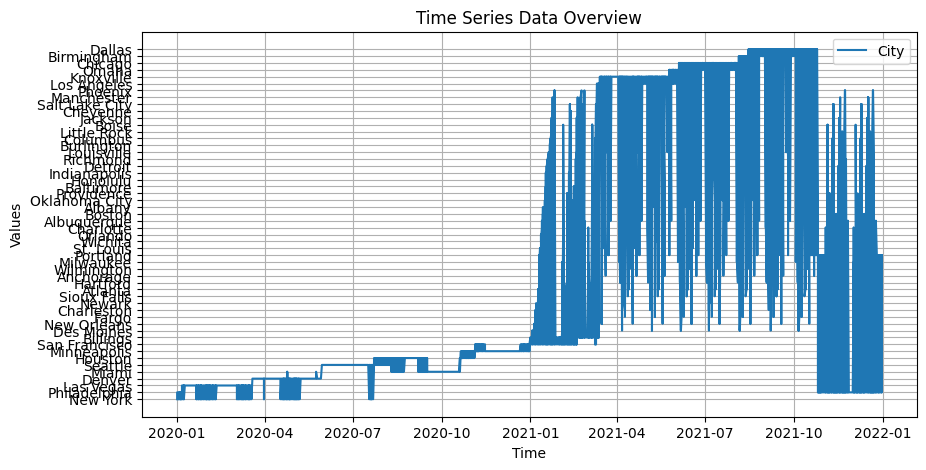

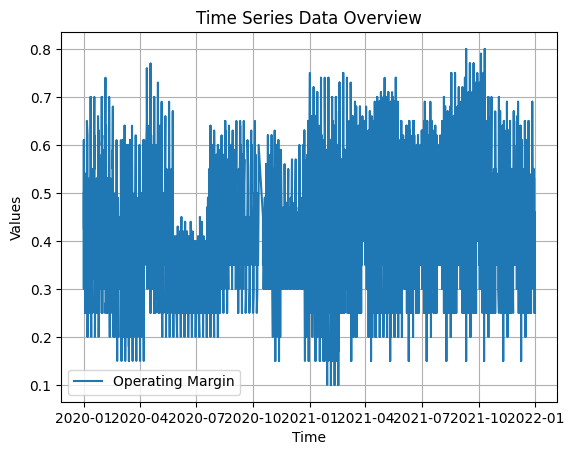

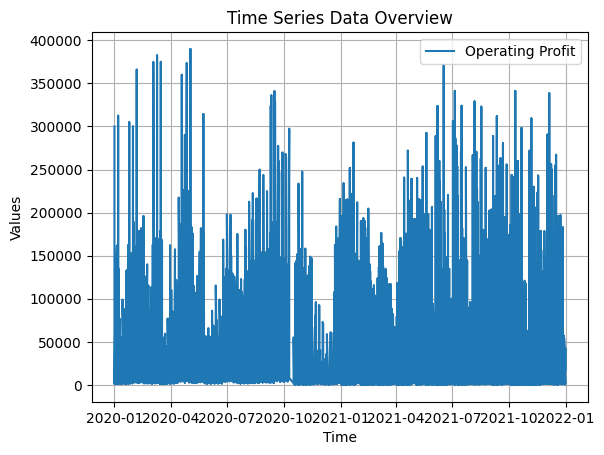

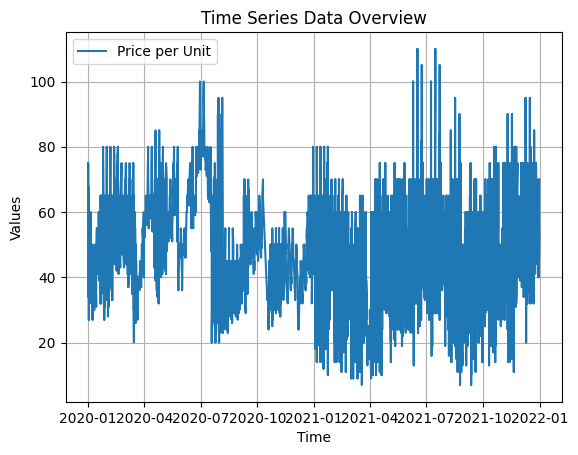

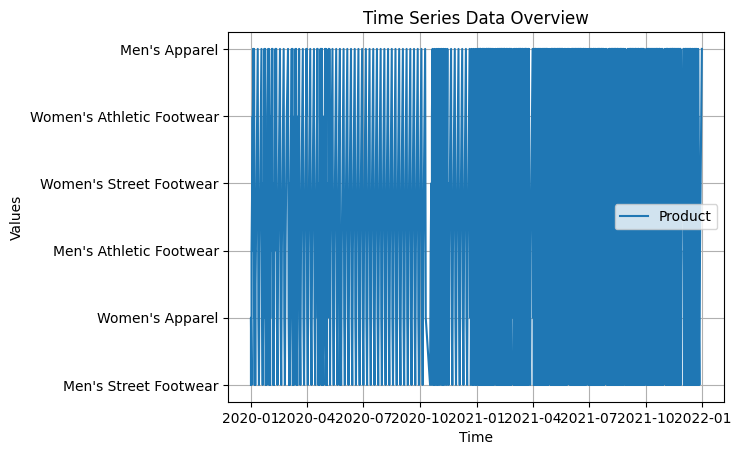

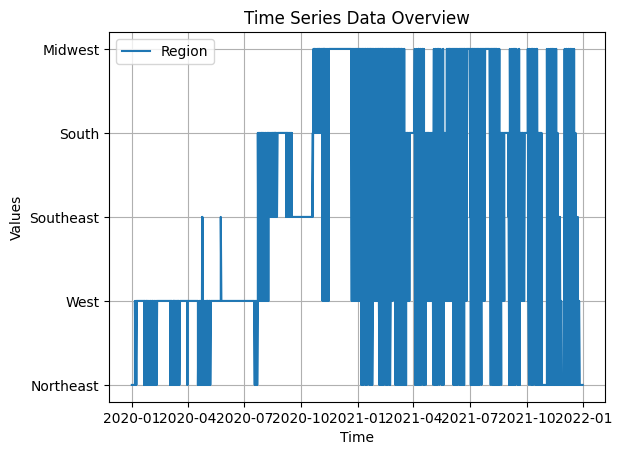

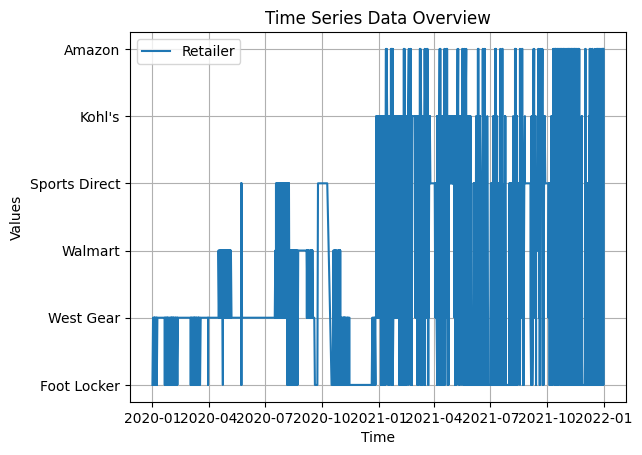

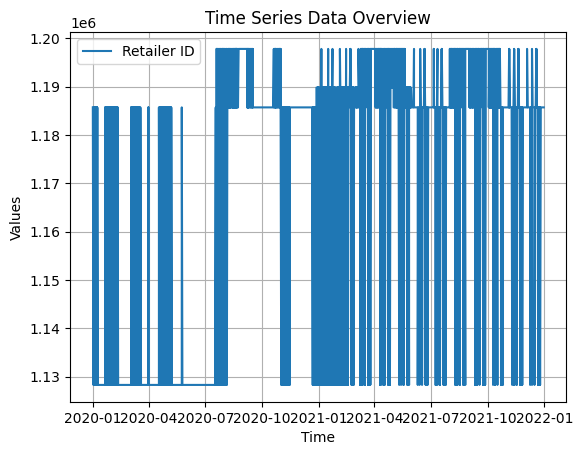

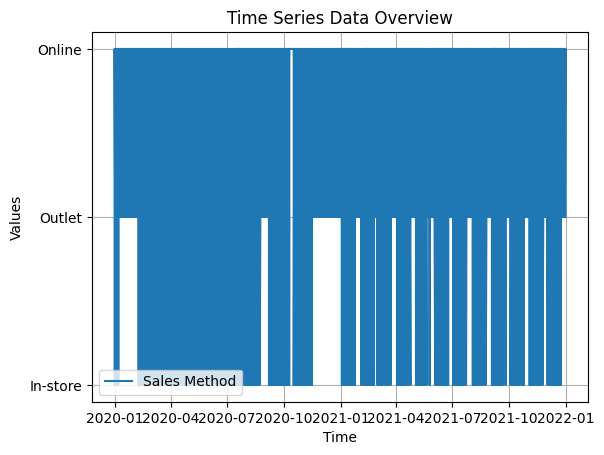

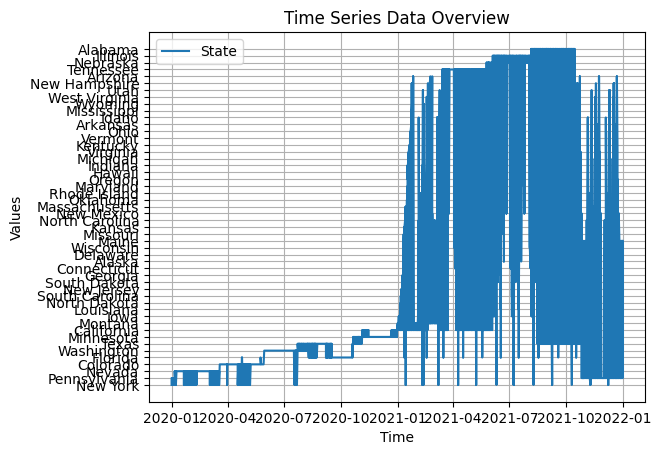

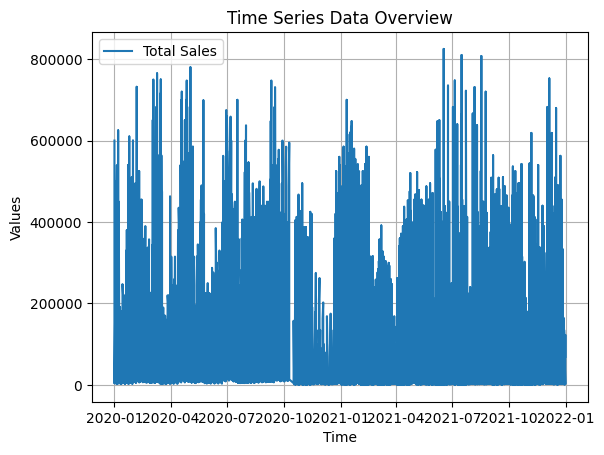

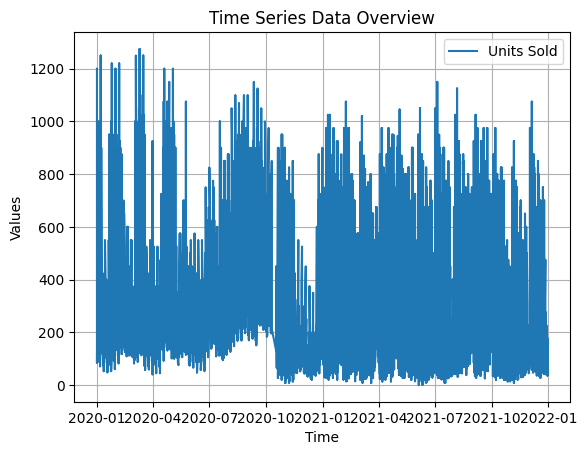


Checking column: Region (Type: category)
No specific checks for type: category

Checking column: State (Type: category)
No specific checks for type: category

Checking column: City (Type: category)
No specific checks for type: category

Checking column: Product (Type: category)
No specific checks for type: category

Checking column: Price per Unit (Type: float32)
Running checks for numerical data...
Statistical Summary:
        Price per Unit
count     9648.000000
mean        45.216625
std         14.705397
min          7.000000
25%         35.000000
50%         45.000000
75%         55.000000
max        110.000000


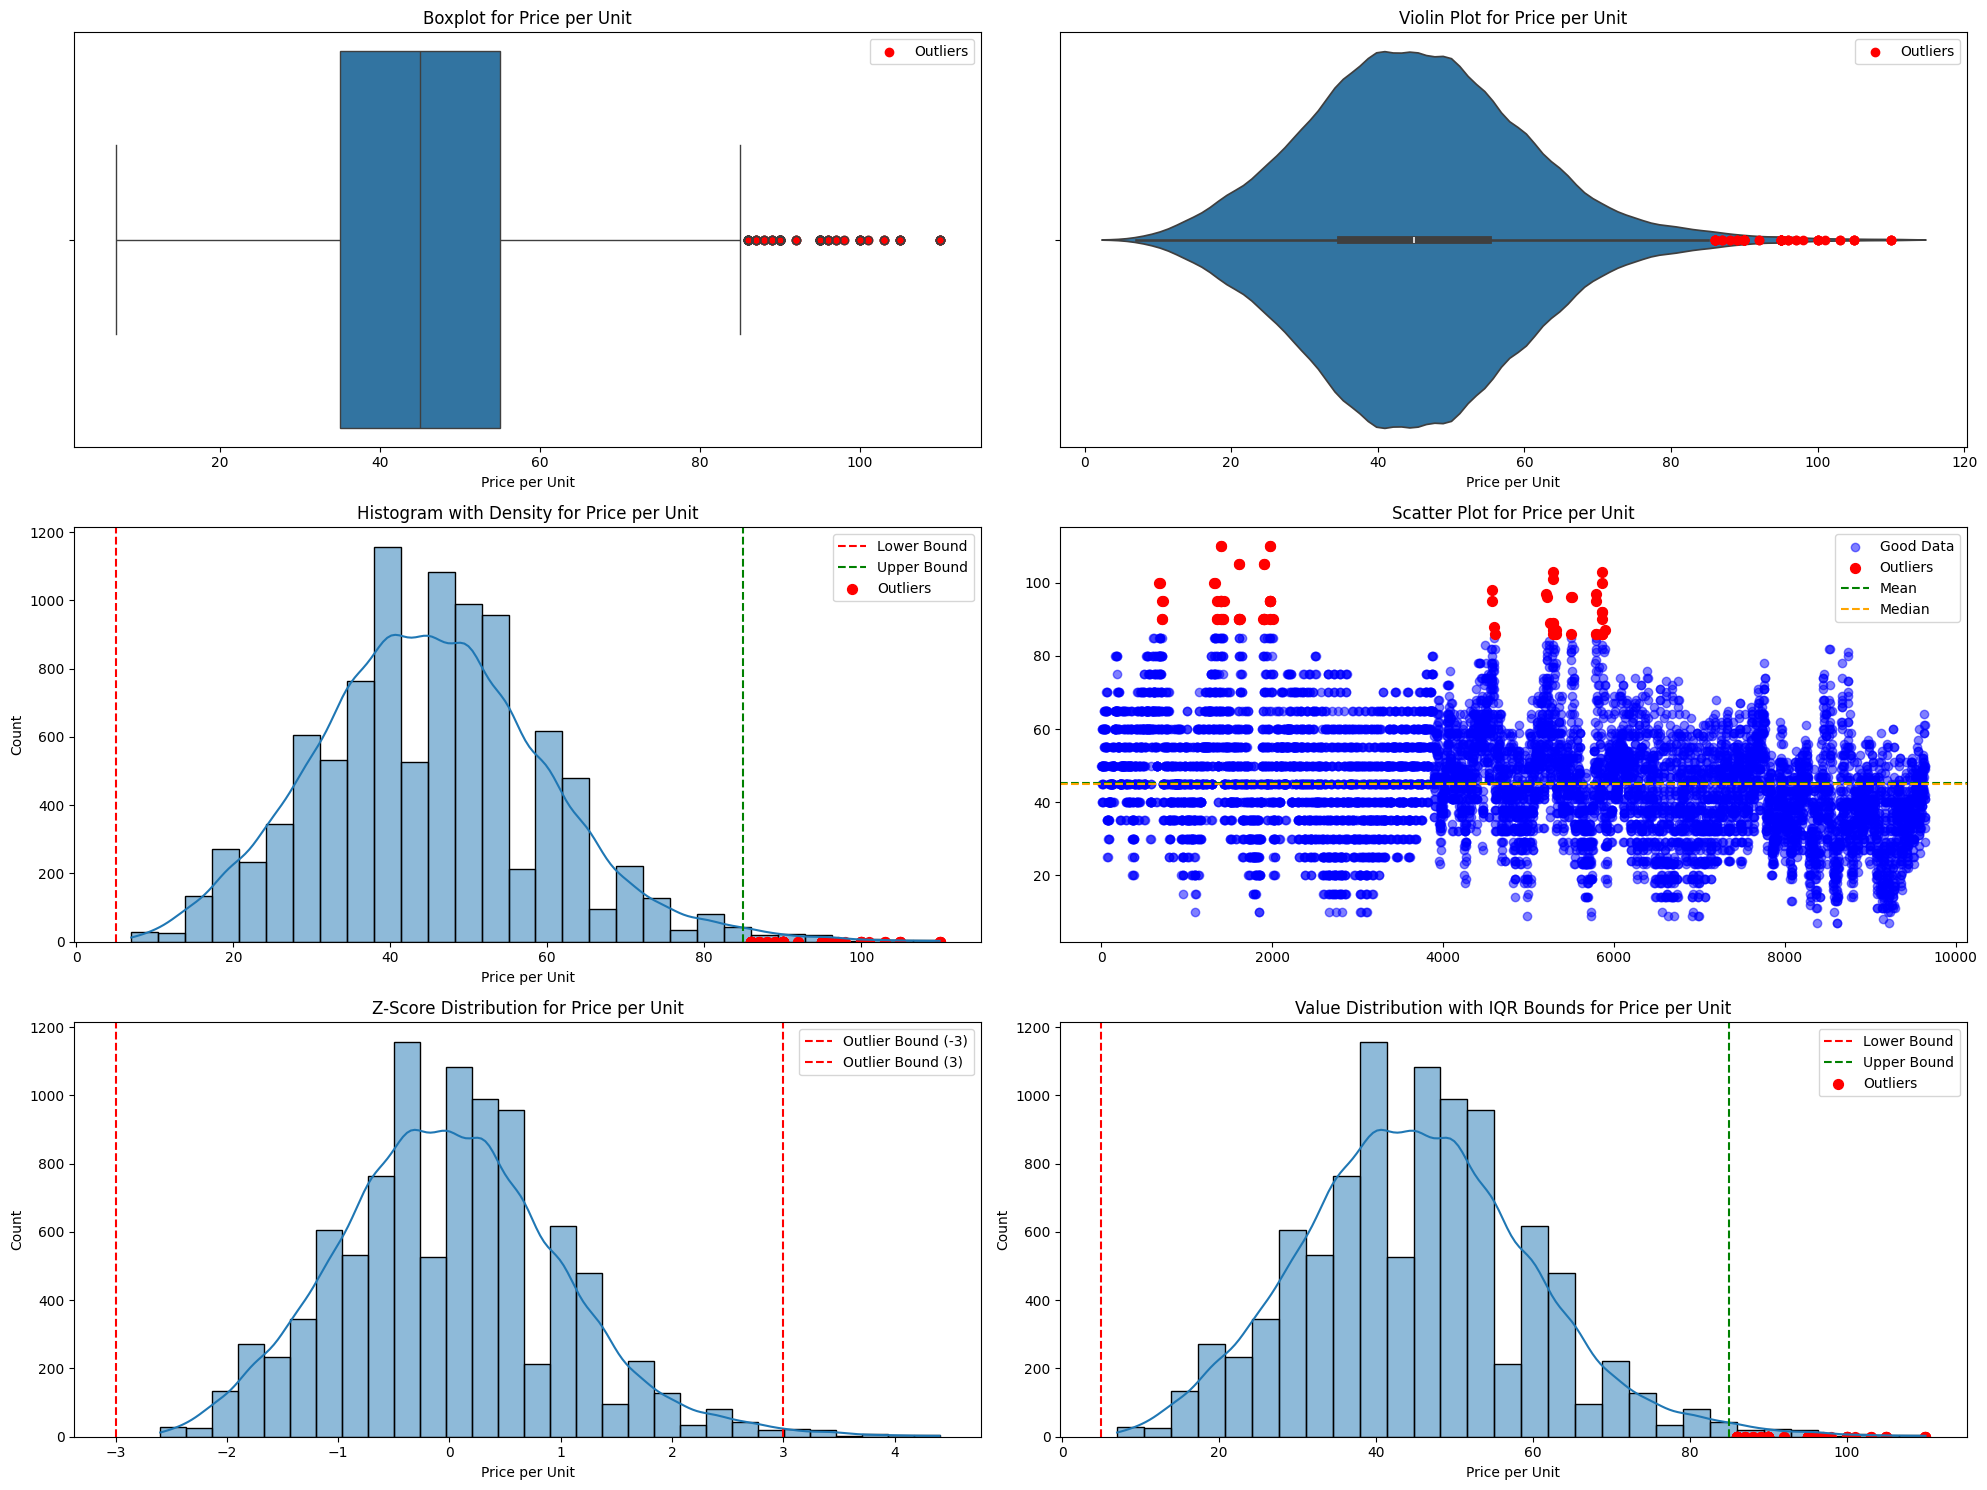

Outliers detected in column Price per Unit:
      Price per Unit
4567            98.0
679            100.0
685            100.0
4573            95.0
708             90.0
...              ...
5317            86.0
5318            87.0
1430            95.0
2006            90.0
1429            90.0

[81 rows x 1 columns]
Result: Bad (Presence of outliers)
Outliers in Price per Unit: 62 (Result: Bad)


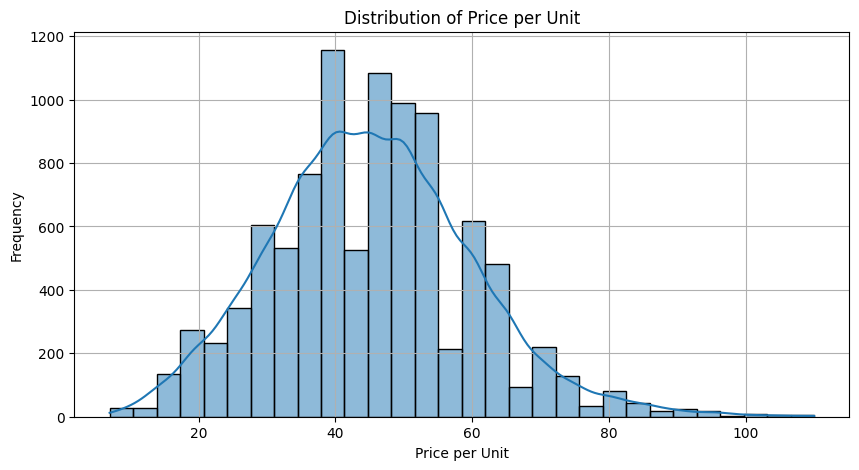

Skewness:
 Price per Unit    0.362446
dtype: float32

Kurtosis:
 Price per Unit    0.430186
dtype: float32
Price per Unit - Skewness: 0.3624 (Normal), Kurtosis: 0.4302 (Normal)

Checking column: Units Sold (Type: int16)
Running checks for numerical data...
Statistical Summary:
         Units Sold
count  9648.000000
mean    256.930037
std     214.252030
min       0.000000
25%     106.000000
50%     176.000000
75%     350.000000
max    1275.000000


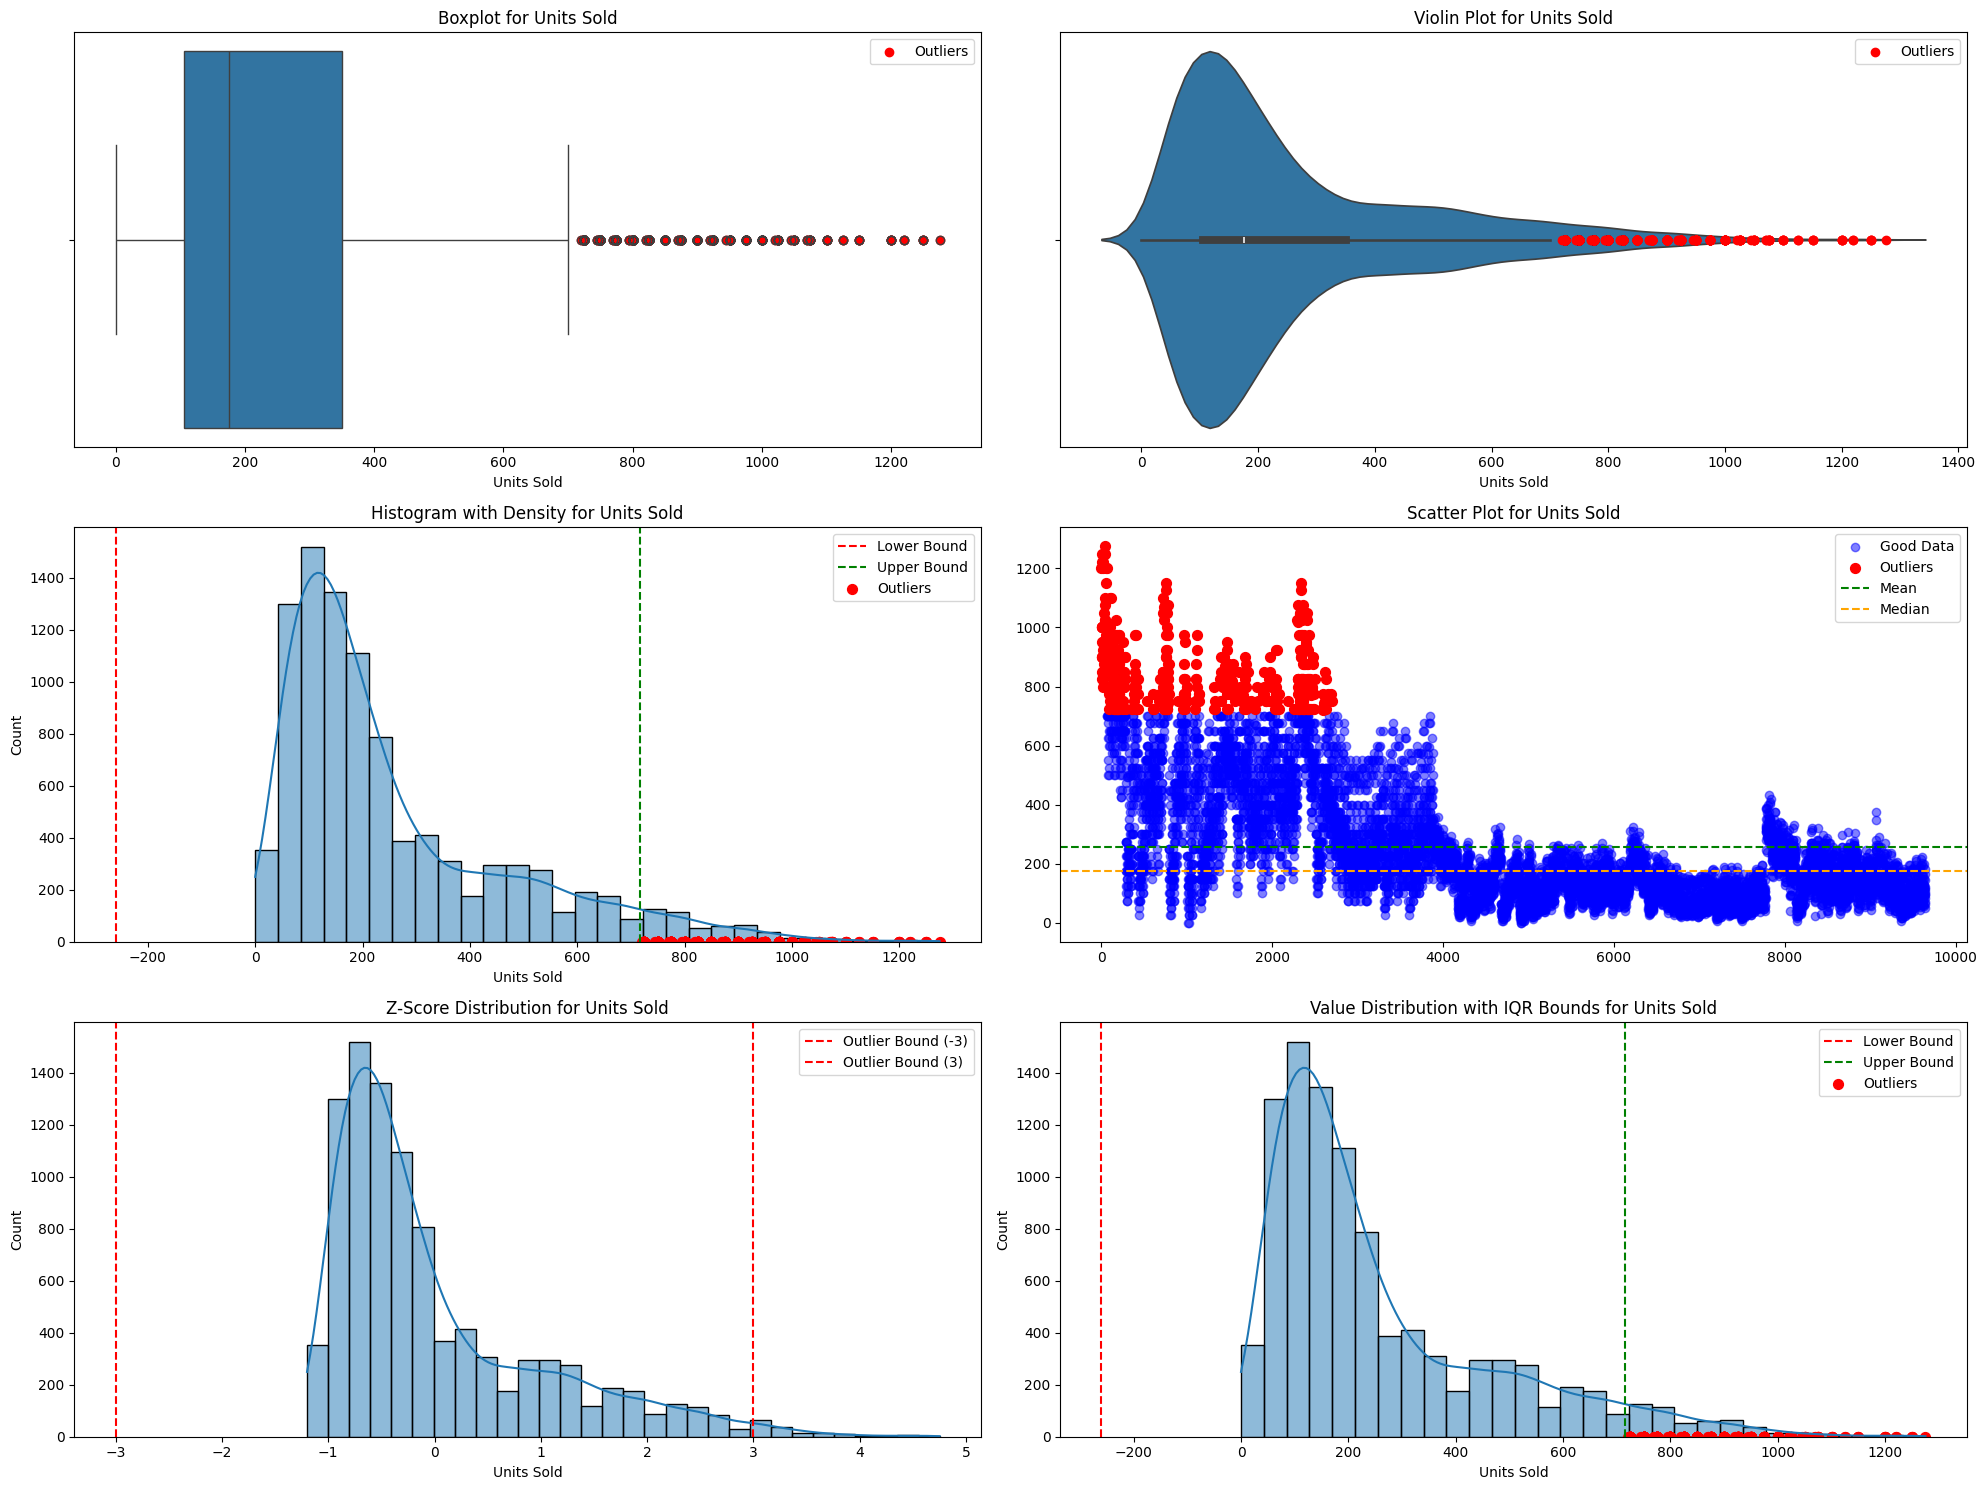

Outliers detected in column Units Sold:
      Units Sold
0           1200
1           1000
2           1000
3            850
4            900
...          ...
2002         800
1930         750
1642         750
1641         750
1929         750

[508 rows x 1 columns]
Result: Bad (Presence of outliers)
Outliers in Units Sold: 154 (Result: Bad)


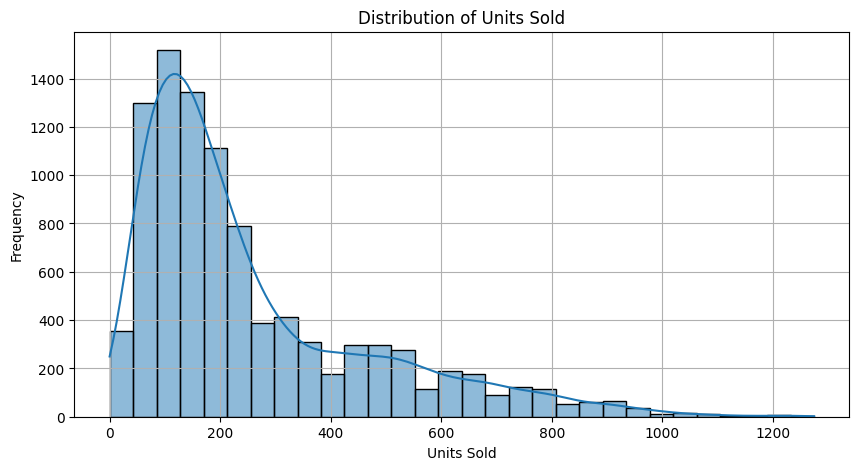

Skewness:
 Units Sold    1.462257
dtype: float64

Kurtosis:
 Units Sold    1.699699
dtype: float64
Units Sold - Skewness: 1.4623 (Skewed), Kurtosis: 1.6997 (Normal)

Checking column: Total Sales (Type: float32)
Running checks for numerical data...
Statistical Summary:
          Total Sales
count    9648.000000
mean    93273.429688
std    141916.015625
min         0.000000
25%      4254.500000
50%      9576.000000
75%    150000.000000
max    825000.000000


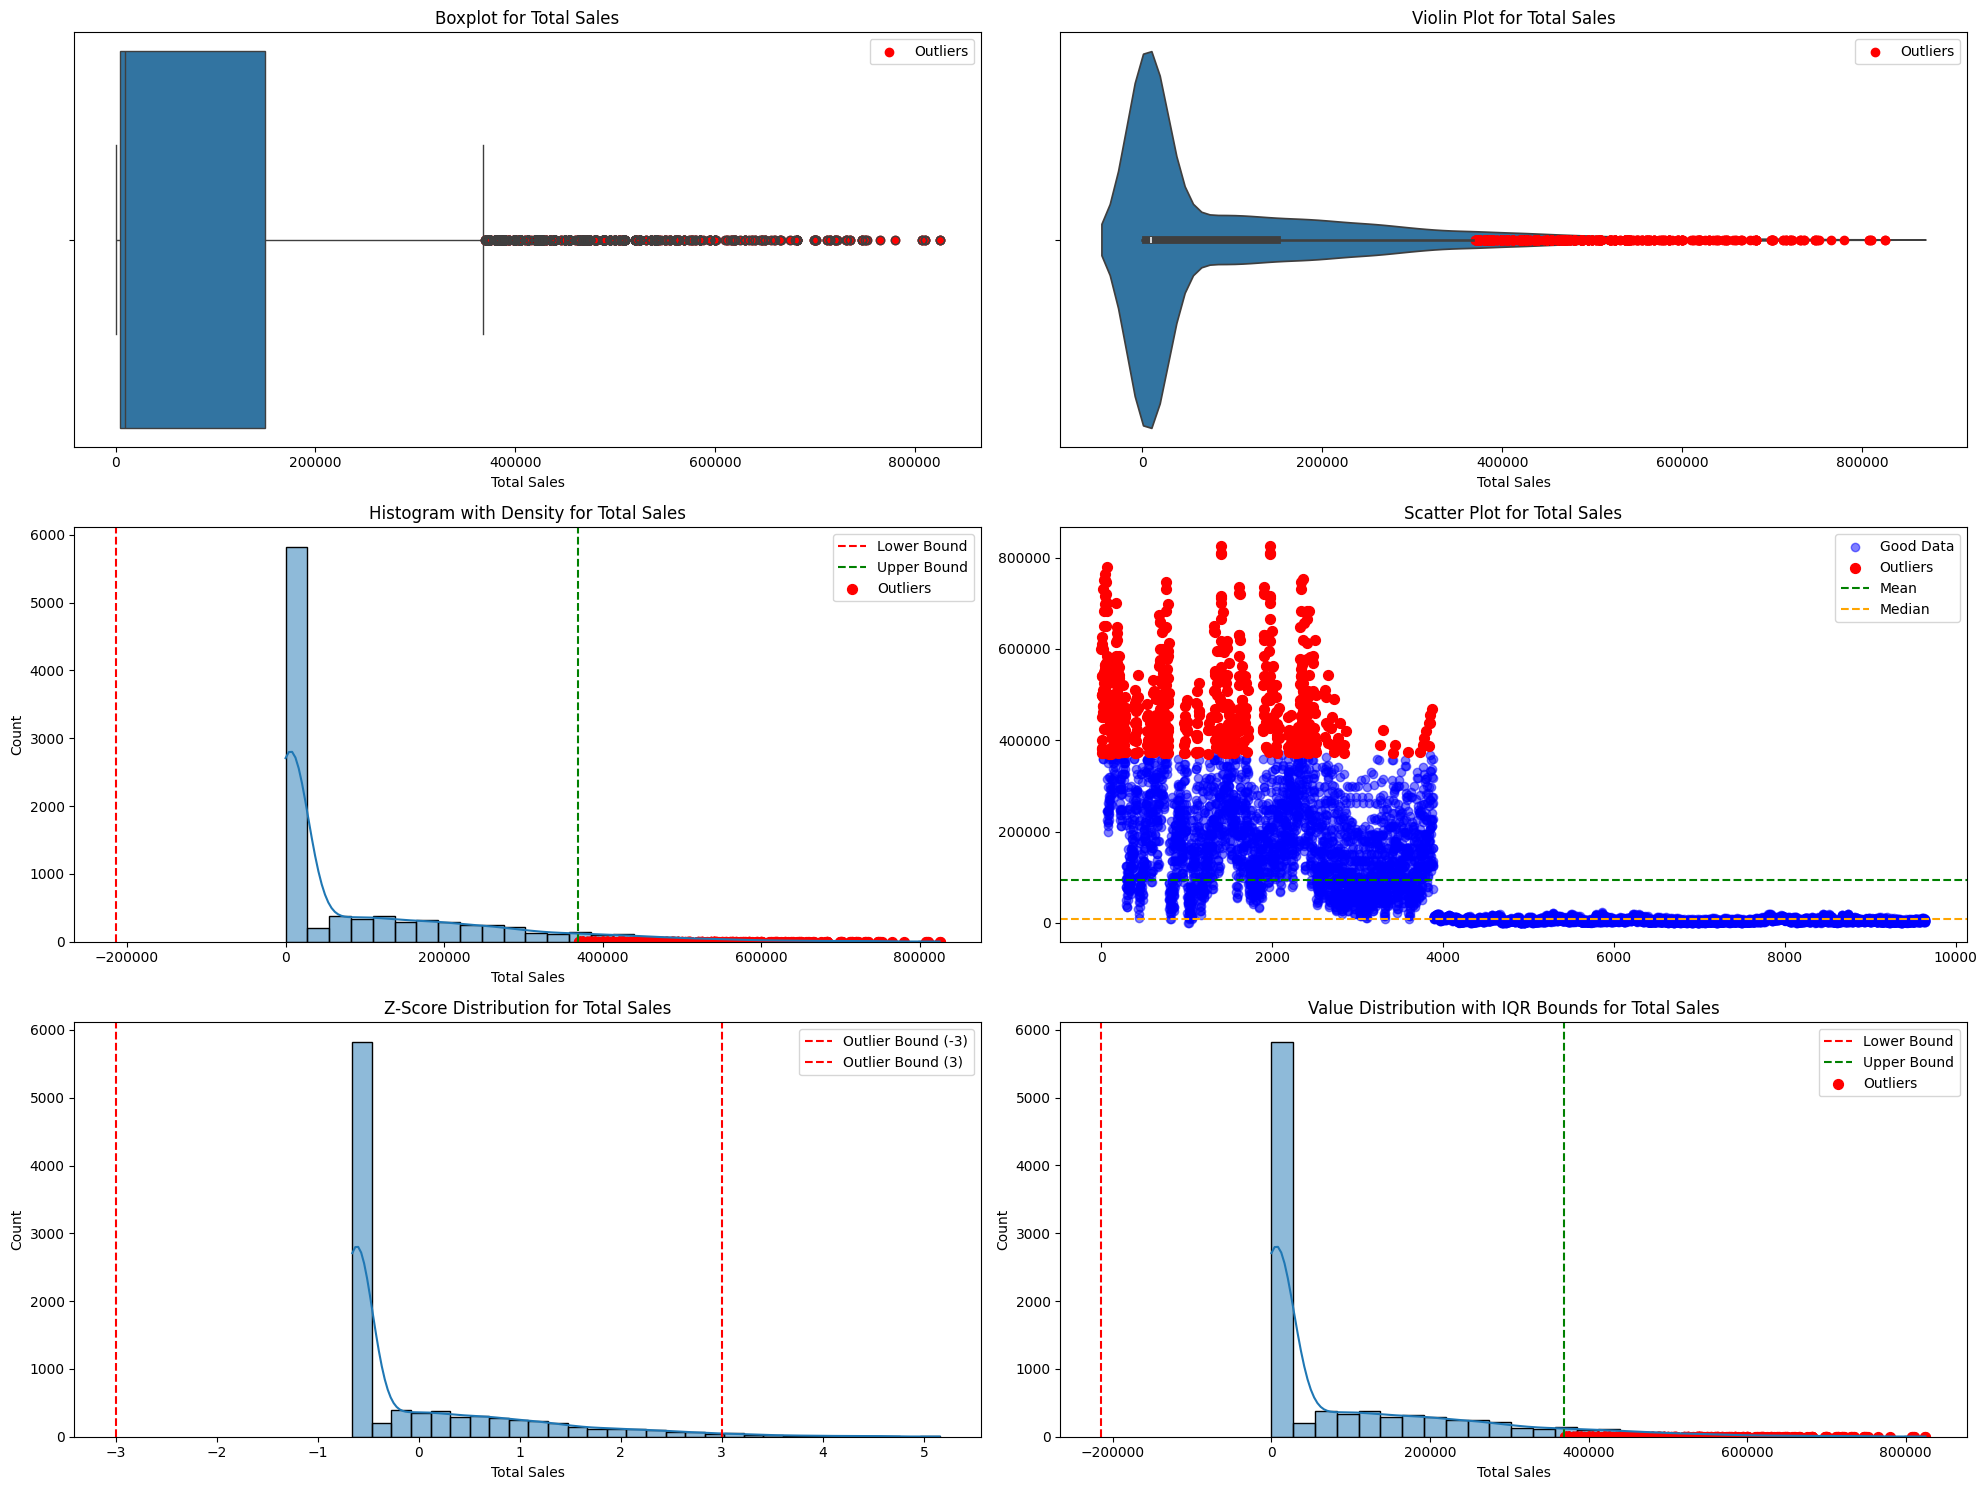

Outliers detected in column Total Sales:
      Total Sales
0        600000.0
1        500000.0
2        400000.0
3        382500.0
4        540000.0
...           ...
1641     487500.0
1929     487500.0
2217     420000.0
2222     393750.0
2218     455000.0

[653 rows x 1 columns]
Result: Bad (Presence of outliers)
Outliers in Total Sales: 189 (Result: Bad)


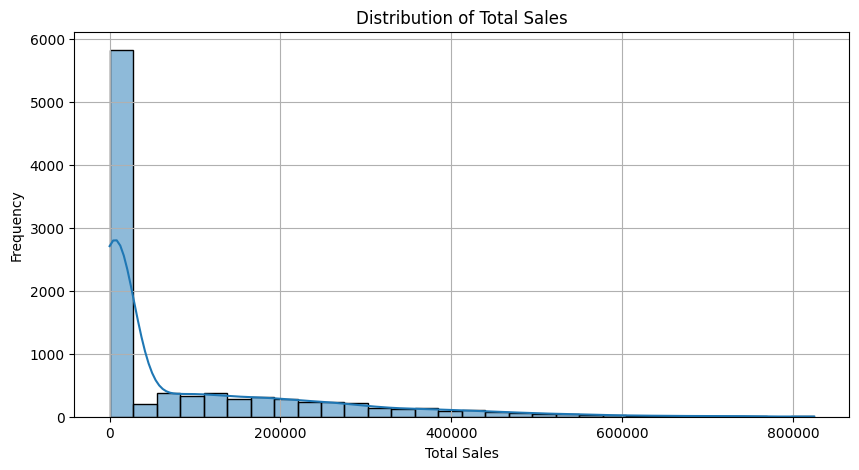

Skewness:
 Total Sales    1.841359
dtype: float32

Kurtosis:
 Total Sales    3.143842
dtype: float32
Total Sales - Skewness: 1.8414 (Skewed), Kurtosis: 3.1438 (Heavy-tailed)

Checking column: Operating Profit (Type: float32)
Running checks for numerical data...
Statistical Summary:
        Operating Profit
count       9648.000000
mean       34425.242188
std        54193.113281
min            0.000000
25%         1921.752533
50%         4371.419922
75%        52062.500000
max       390000.000000


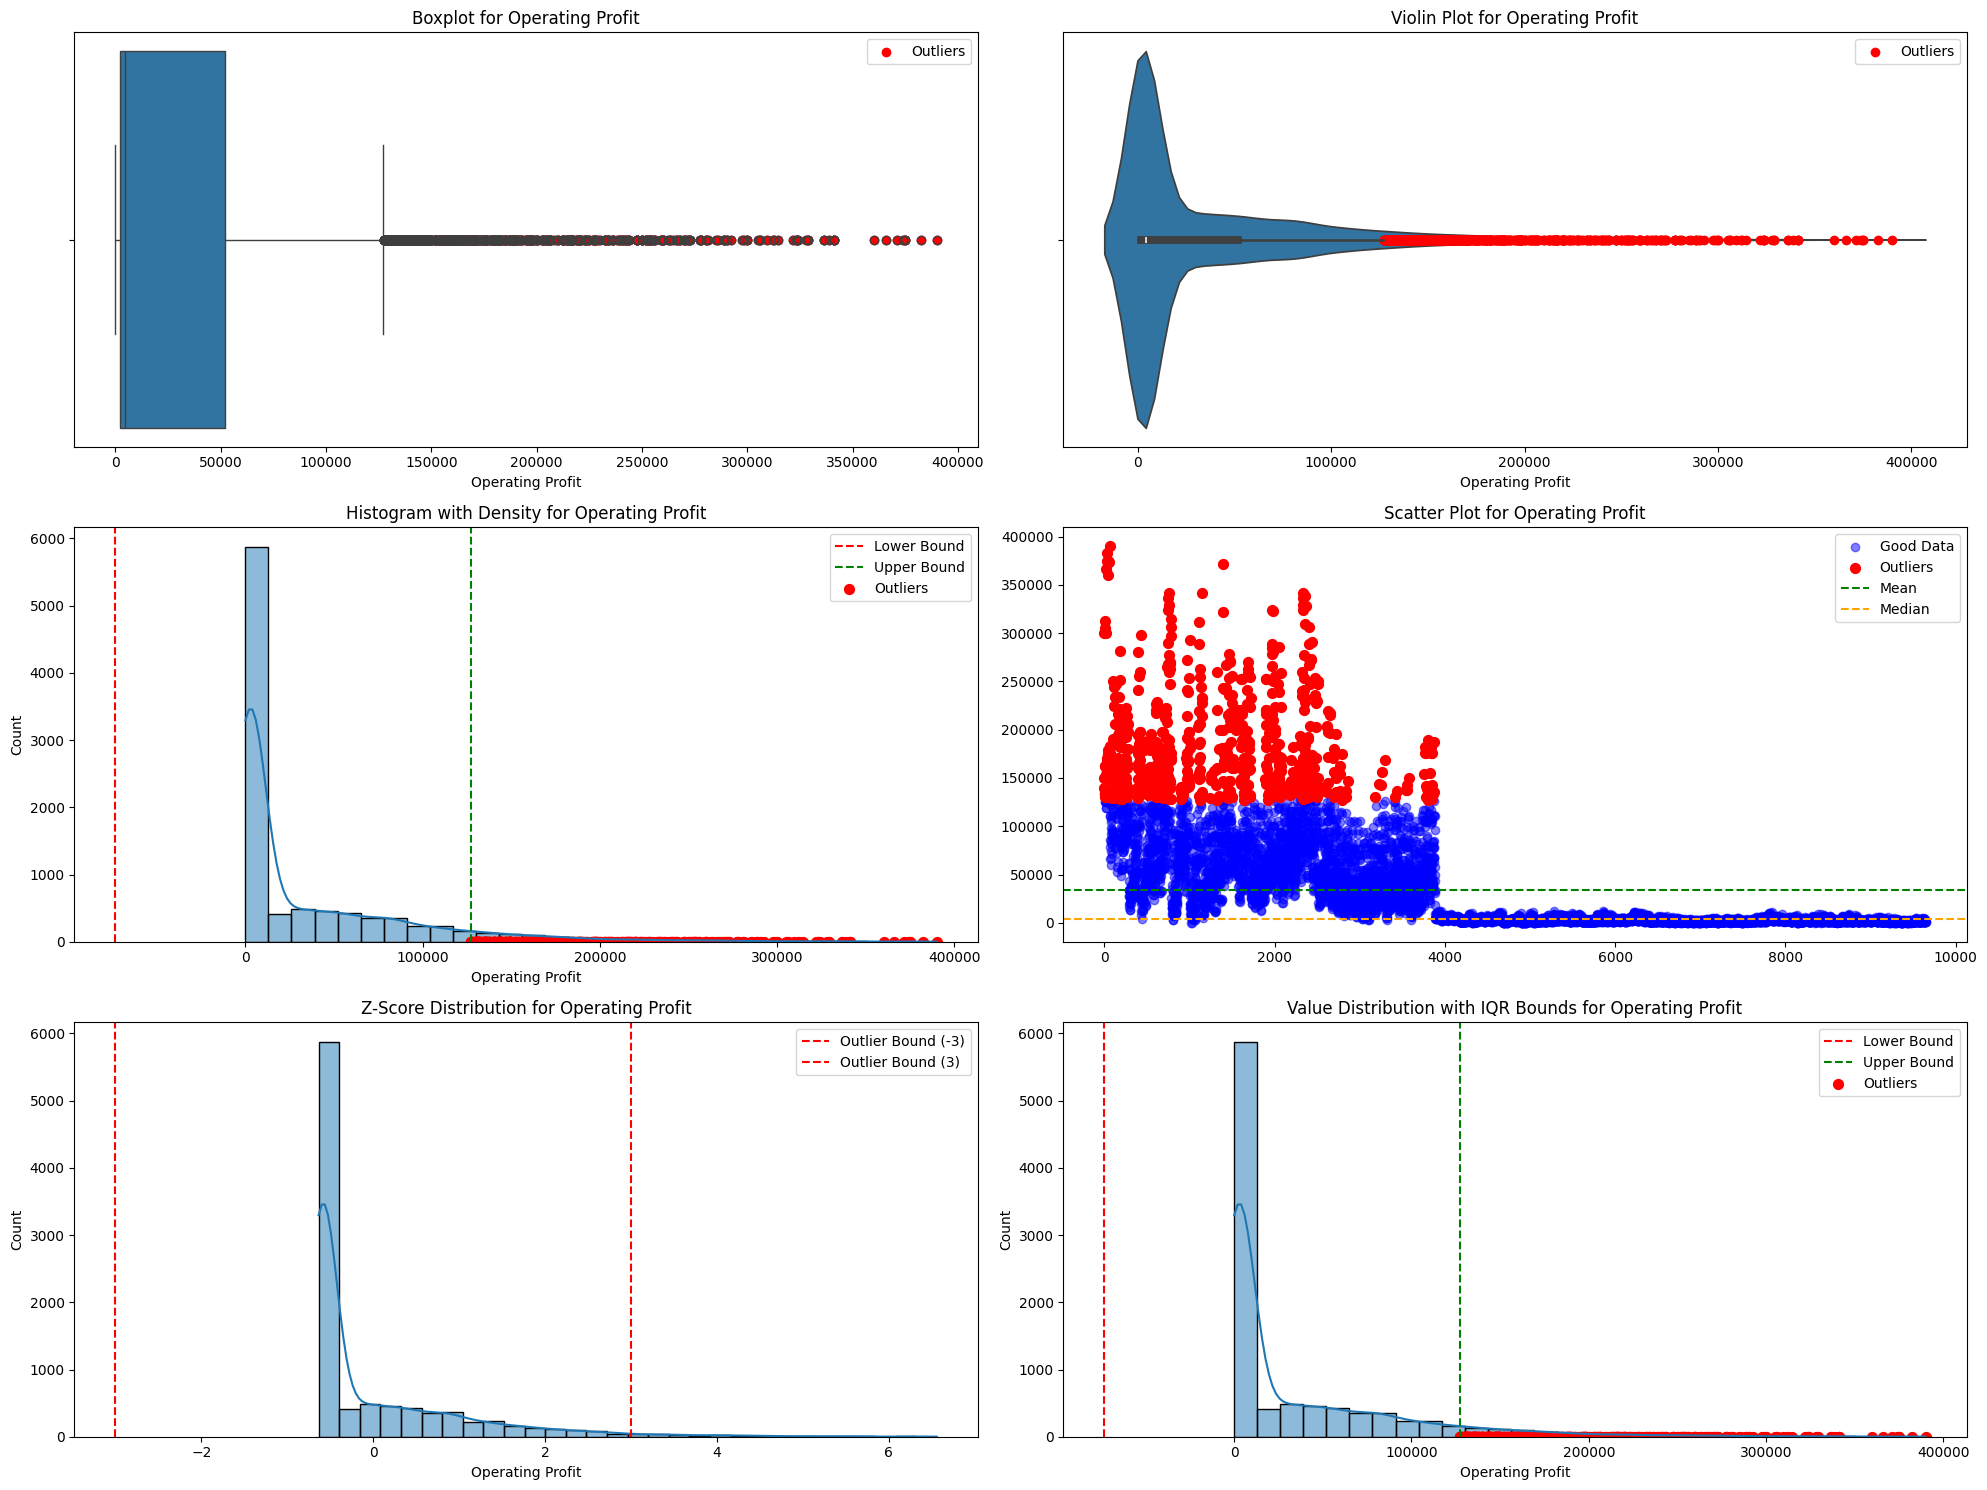

Outliers detected in column Operating Profit:
      Operating Profit
0             300000.0
1             150000.0
2             140000.0
3             133875.0
4             162000.0
...                ...
1641          170625.0
1929          170625.0
2217          147000.0
2218          182000.0
494           182875.0

[706 rows x 1 columns]
Result: Bad (Presence of outliers)
Outliers in Operating Profit: 204 (Result: Bad)


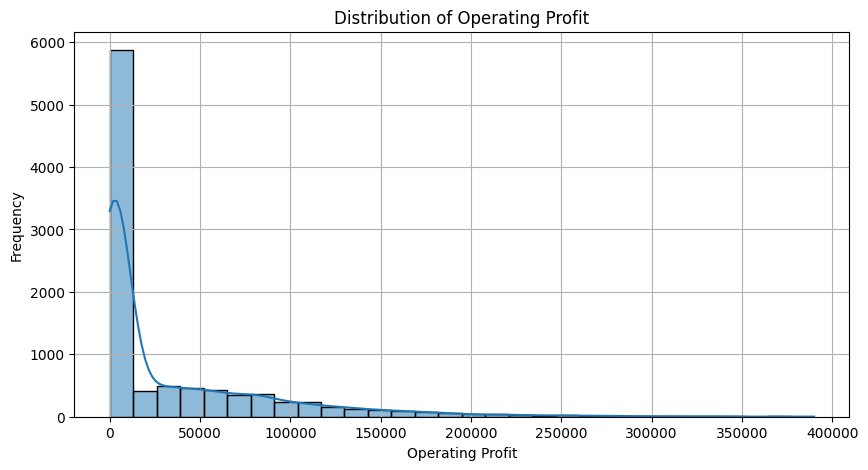

Skewness:
 Operating Profit    2.233598
dtype: float32

Kurtosis:
 Operating Profit    5.820367
dtype: float32
Operating Profit - Skewness: 2.2336 (Skewed), Kurtosis: 5.8204 (Heavy-tailed)

Checking column: Operating Margin (Type: float32)
Running checks for numerical data...
Statistical Summary:
        Operating Margin
count       9648.000000
mean           0.422991
std            0.097197
min            0.100000
25%            0.350000
50%            0.410000
75%            0.490000
max            0.800000


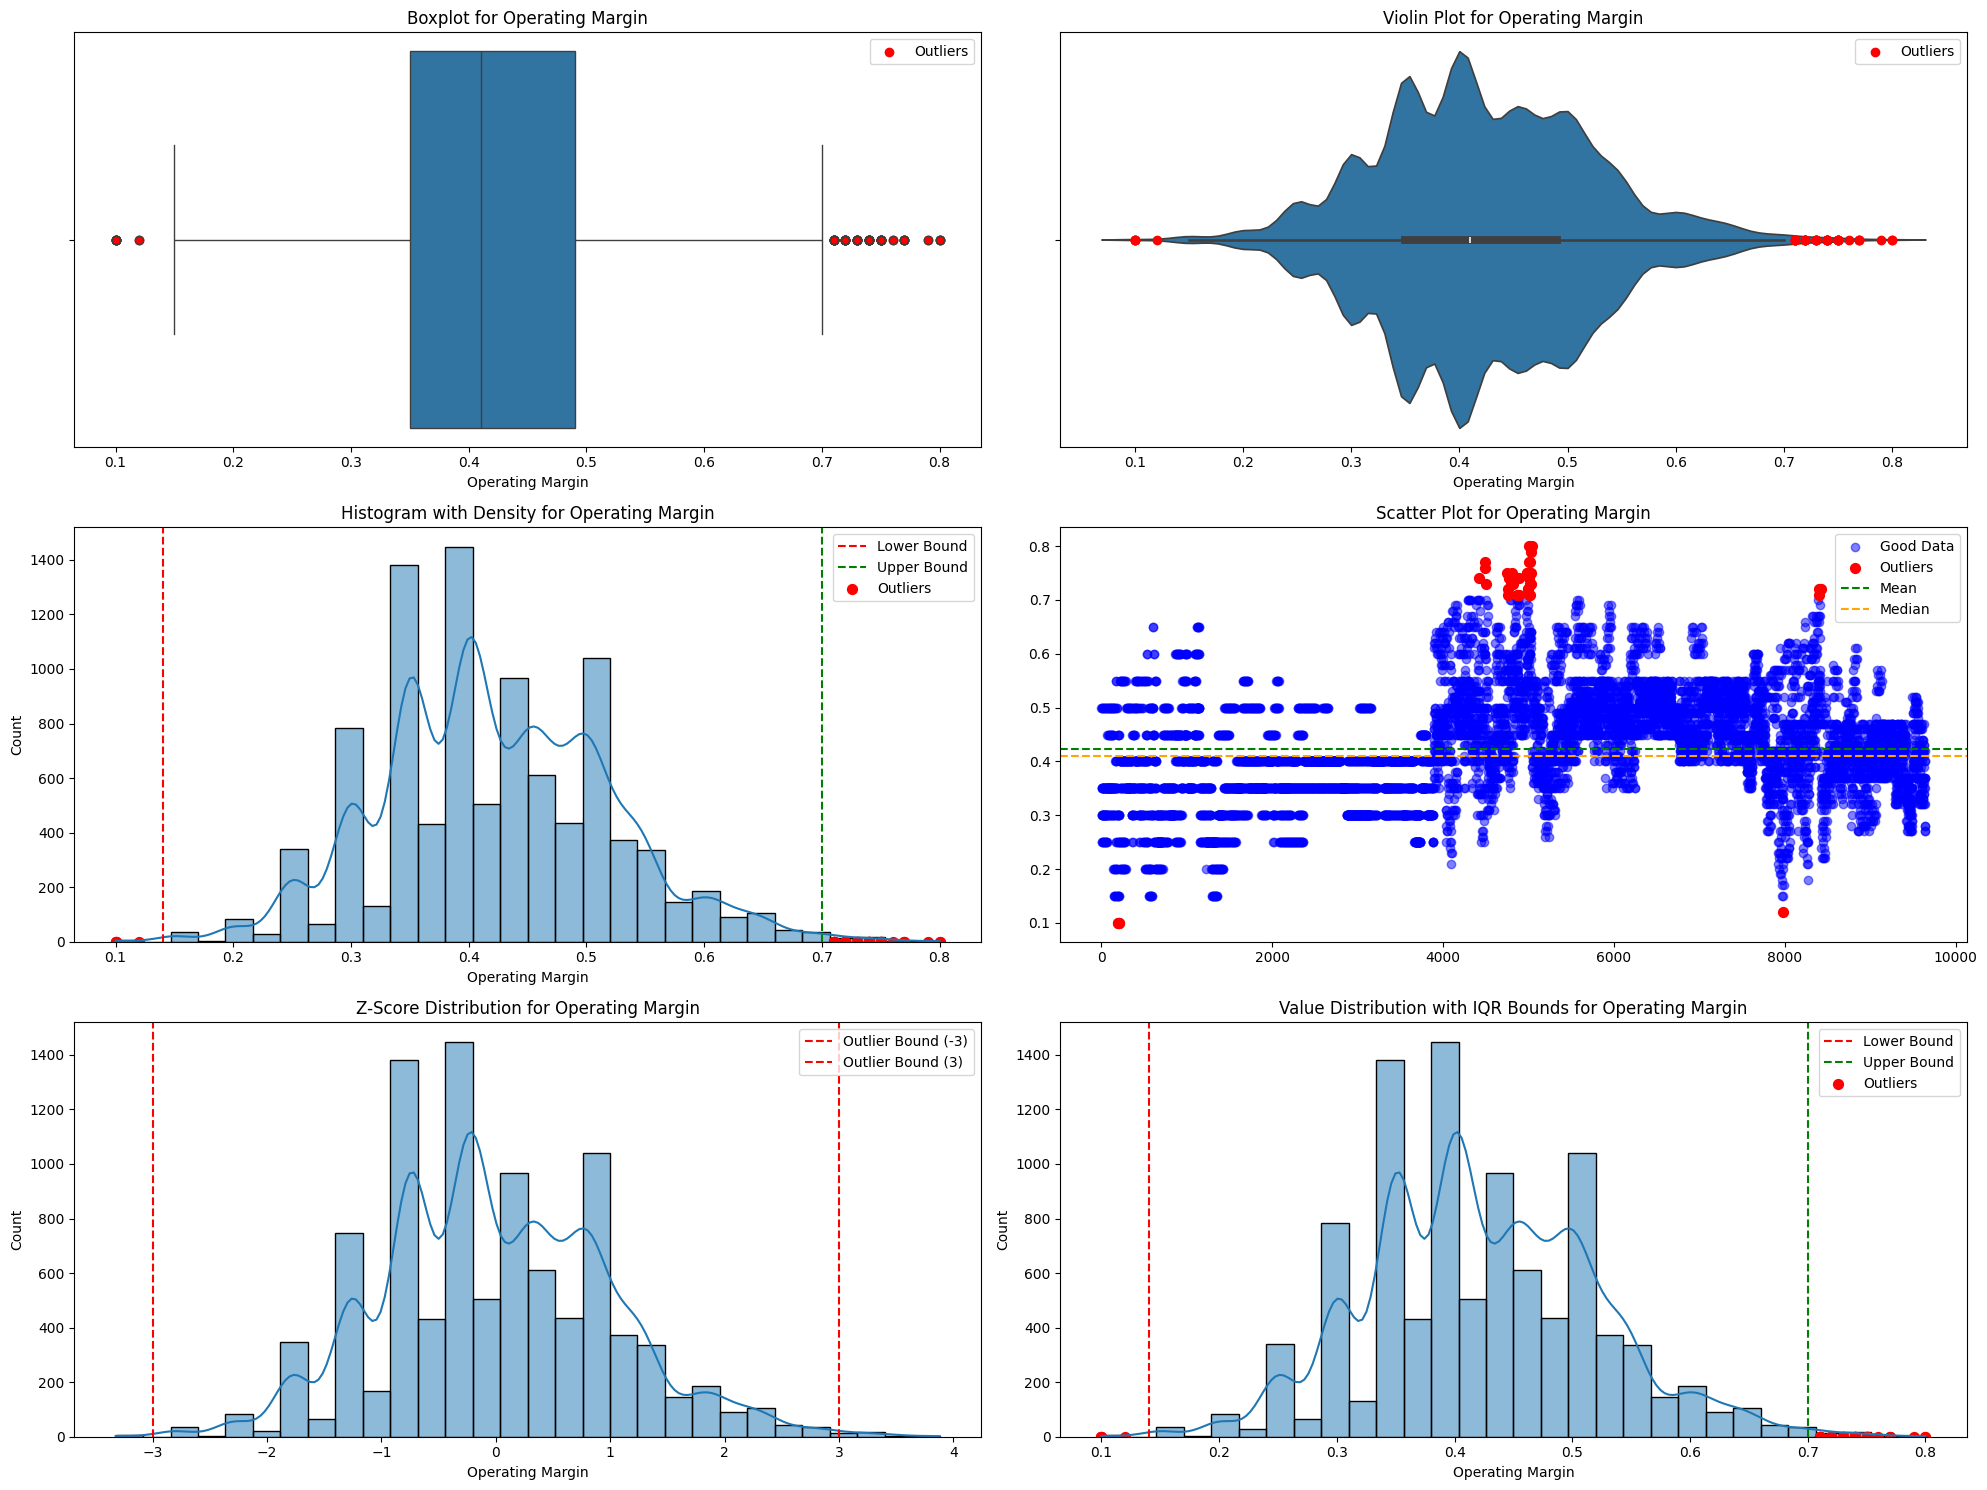

Outliers detected in column Operating Margin:
      Operating Margin
4422              0.74
4488              0.76
4494              0.77
4506              0.73
4752              0.75
4758              0.72
4764              0.71
4770              0.74
4776              0.74
193               0.10
4782              0.74
199               0.10
7975              0.12
205               0.10
211               0.10
4800              0.73
4806              0.75
4812              0.74
4818              0.73
4867              0.71
4873              0.74
4879              0.71
4885              0.71
4891              0.74
4981              0.75
4987              0.75
4993              0.72
4999              0.72
5003              0.74
5005              0.80
5009              0.71
8395              0.71
5011              0.77
5015              0.71
5017              0.77
8401              0.72
5021              0.73
8407              0.72
5023              0.75
5027              0.73
5029       

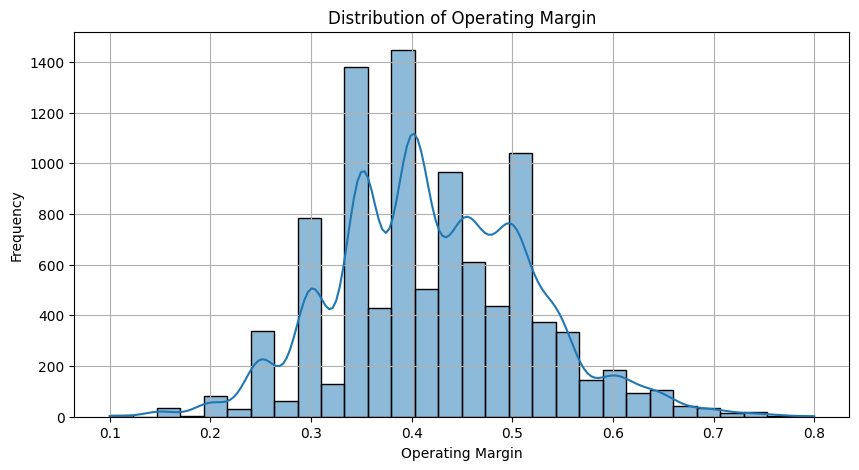

Skewness:
 Operating Margin    0.227481
dtype: float32

Kurtosis:
 Operating Margin    0.175296
dtype: float32
Operating Margin - Skewness: 0.2275 (Normal), Kurtosis: 0.1753 (Normal)

Checking column: Sales Method (Type: category)
No specific checks for type: category


In [11]:
# Run type-specific checks
run_type_specific_checks(start_data)

In [12]:
# Calculate VIF and generate a profile report
calculate_vif(start_data.select_dtypes(include=[np.number]))

Variance Inflation Factor:
             Feature        VIF
0       Retailer ID  46.389340
1    Price per Unit  14.118703
2        Units Sold  17.246072
3       Total Sales  32.931501
4  Operating Profit  22.315579
5  Operating Margin  31.780153


# Data Tranformation

In [16]:
data = summary_data_from_transaction_data(start_data, 'City', 'Invoice Date','Operating Profit', observation_period_end='2021-12-31',
                                            freq='W',)
data.head()

frequency  recency      T  monetary_value
City                                                  
Albany           104.0    104.0  104.0    85833.468750
Albuquerque      104.0    104.0  104.0    61508.355469
Anchorage        104.0    104.0  104.0    43253.328125
Atlanta          104.0    104.0  104.0    66281.632812
Baltimore        104.0    104.0  104.0    23852.947266

## Data Exploration


Checking column: frequency (Type: float64)
Running checks for numerical data...
Statistical Summary:
        frequency
count       52.0
mean       104.0
std          0.0
min        104.0
25%        104.0
50%        104.0
75%        104.0
max        104.0


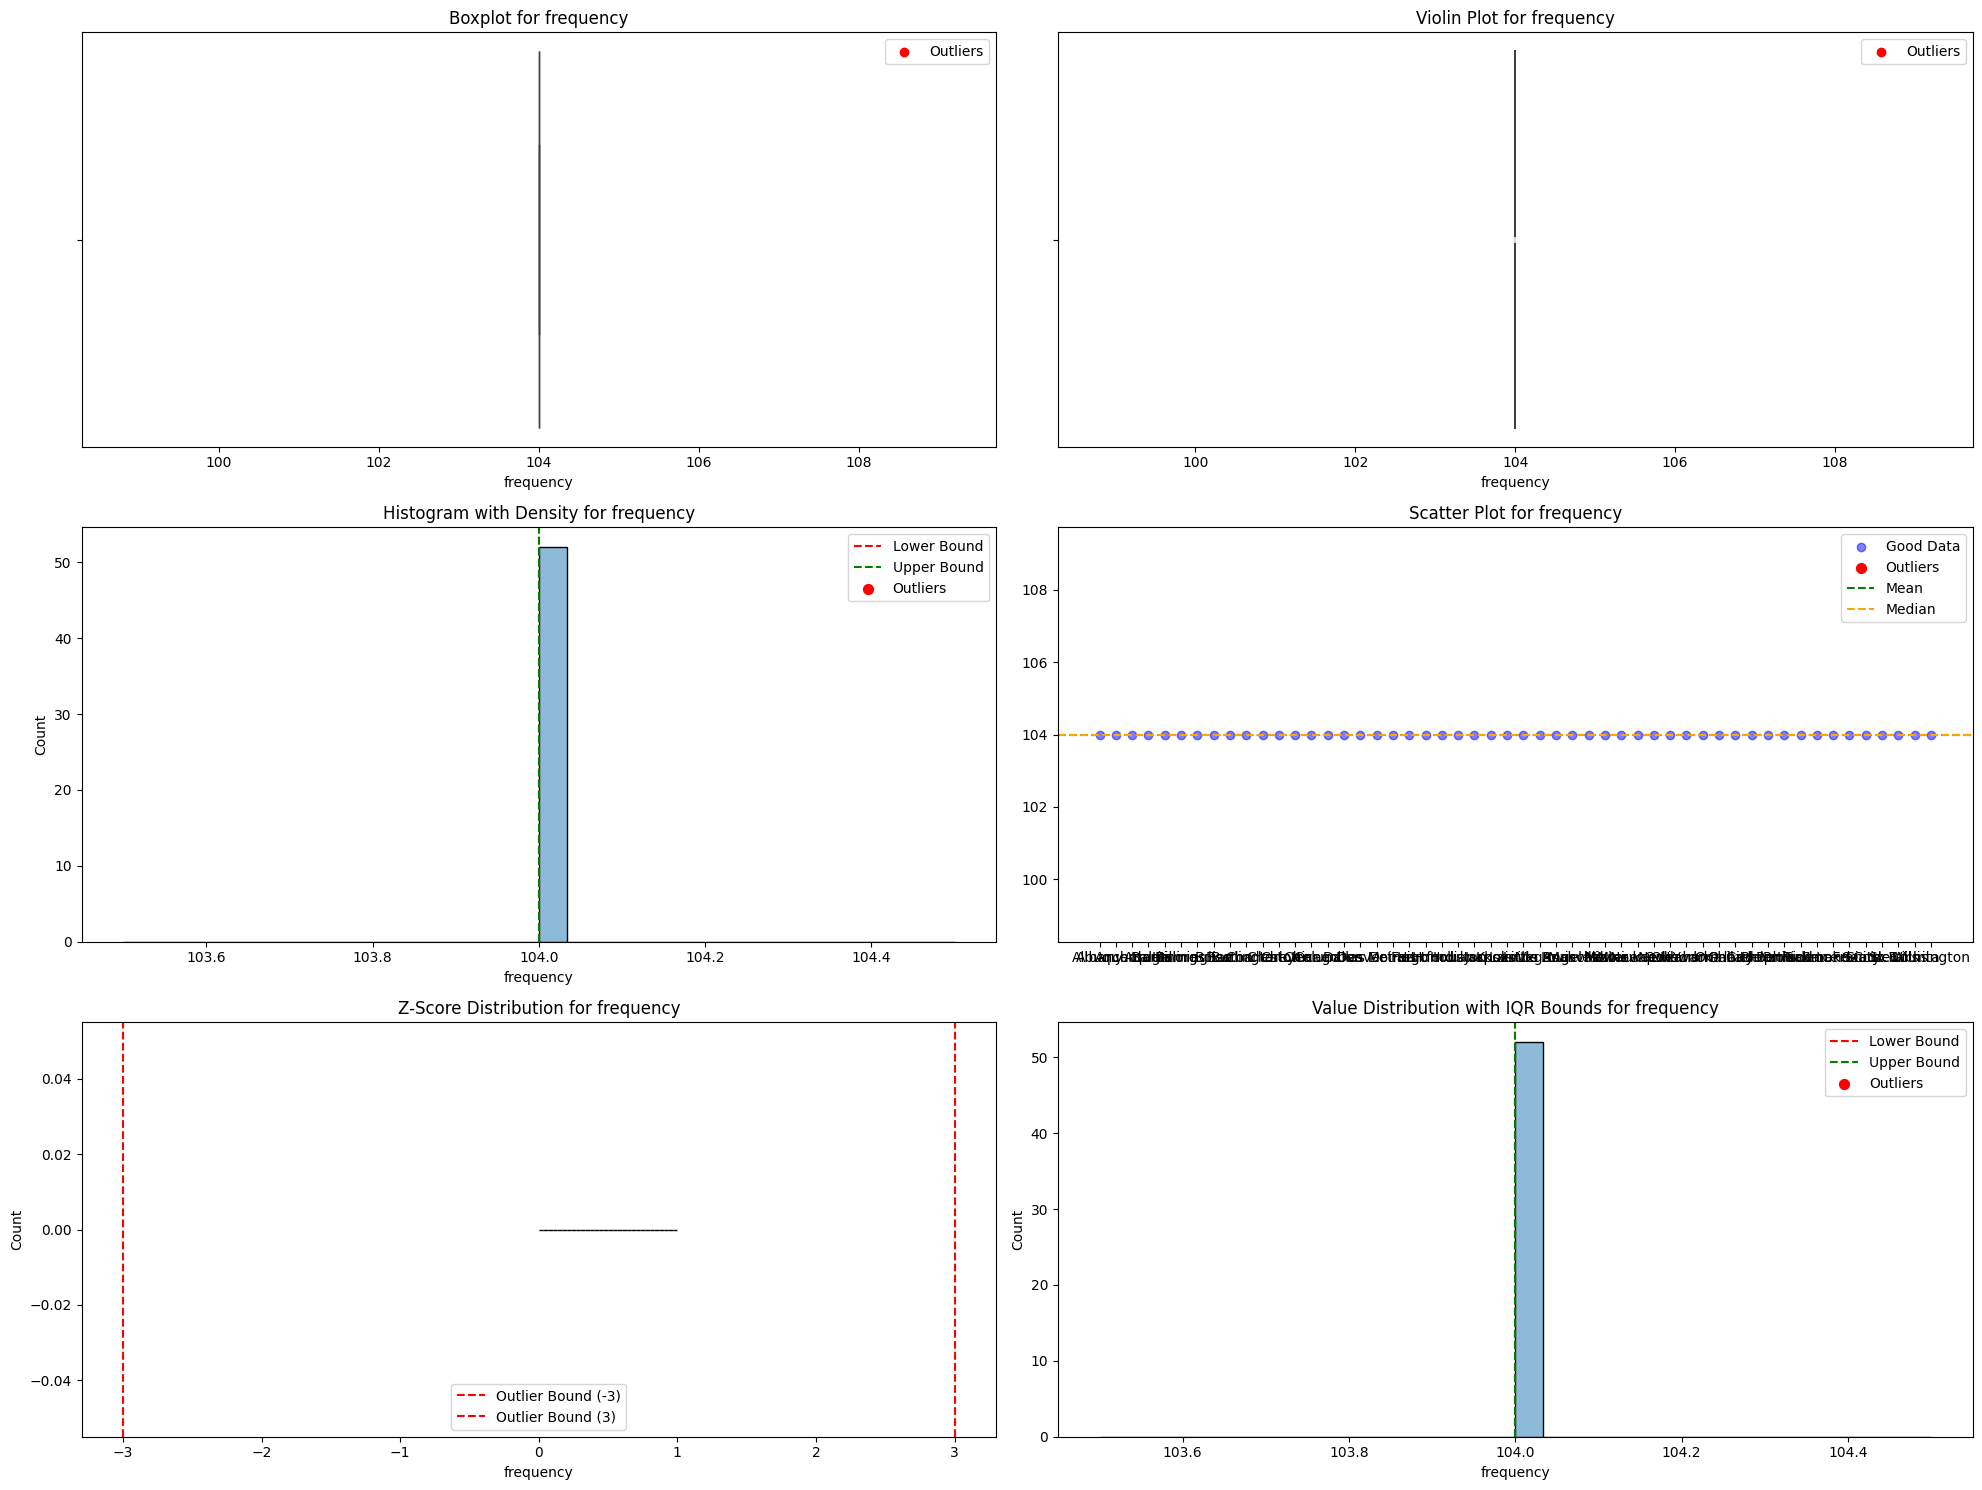

No outliers detected.
Result: Good (No outliers)
No outliers in frequency (Result: Good)


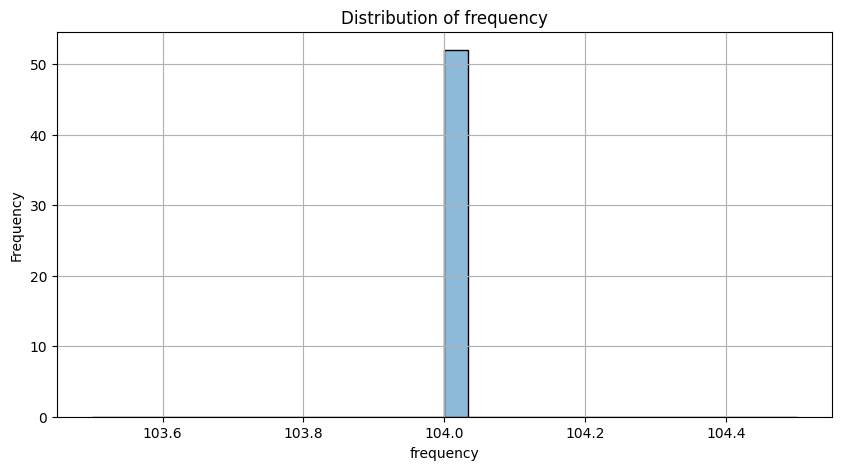

Skewness:
 frequency    0.0
dtype: float64

Kurtosis:
 frequency    0.0
dtype: float64
frequency - Skewness: 0.0000 (Normal), Kurtosis: 0.0000 (Normal)

Checking column: recency (Type: float64)
Running checks for numerical data...
Statistical Summary:
        recency
count     52.0
mean     104.0
std        0.0
min      104.0
25%      104.0
50%      104.0
75%      104.0
max      104.0


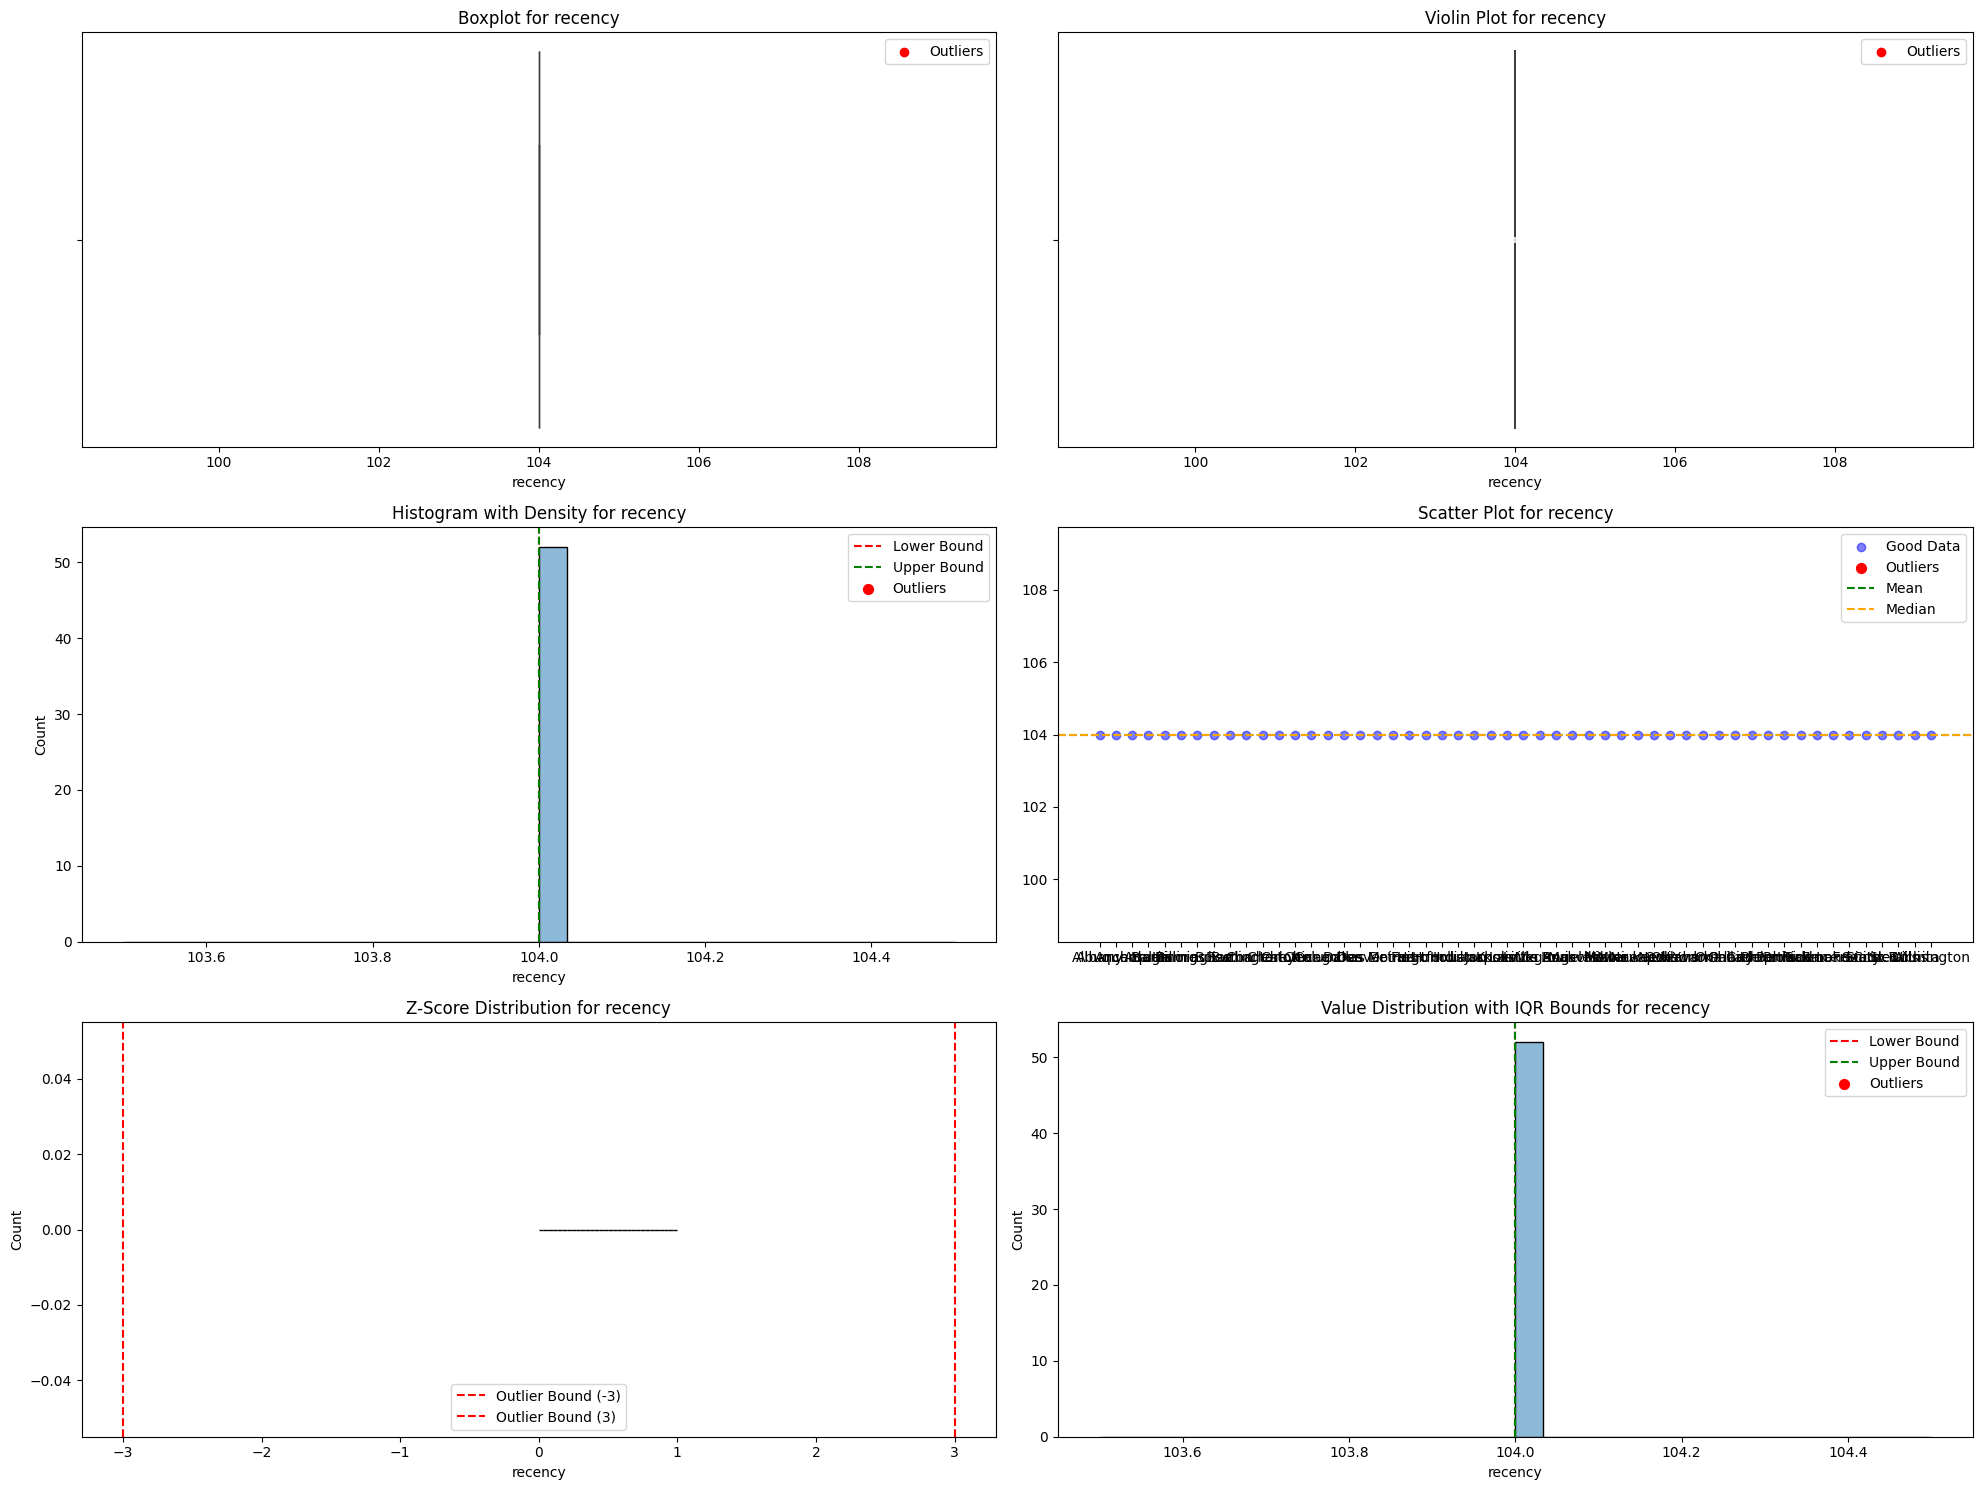

No outliers detected.
Result: Good (No outliers)
No outliers in recency (Result: Good)


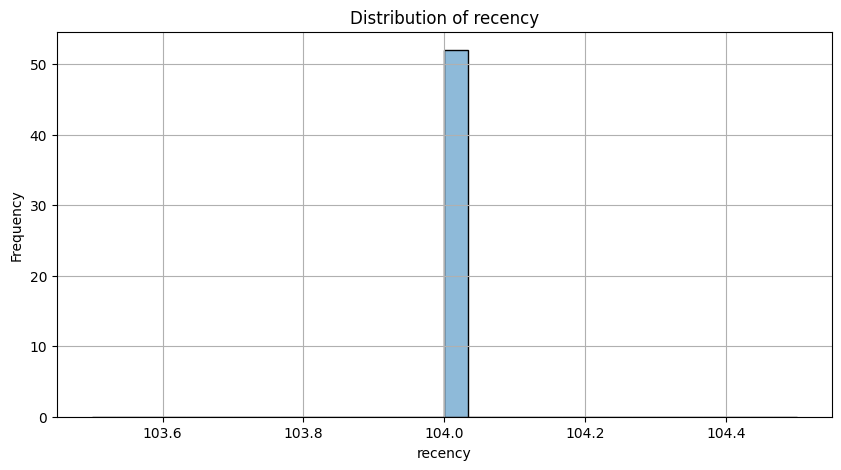

Skewness:
 recency    0.0
dtype: float64

Kurtosis:
 recency    0.0
dtype: float64
recency - Skewness: 0.0000 (Normal), Kurtosis: 0.0000 (Normal)

Checking column: T (Type: float64)
Running checks for numerical data...
Statistical Summary:
            T
count   52.0
mean   104.0
std      0.0
min    104.0
25%    104.0
50%    104.0
75%    104.0
max    104.0


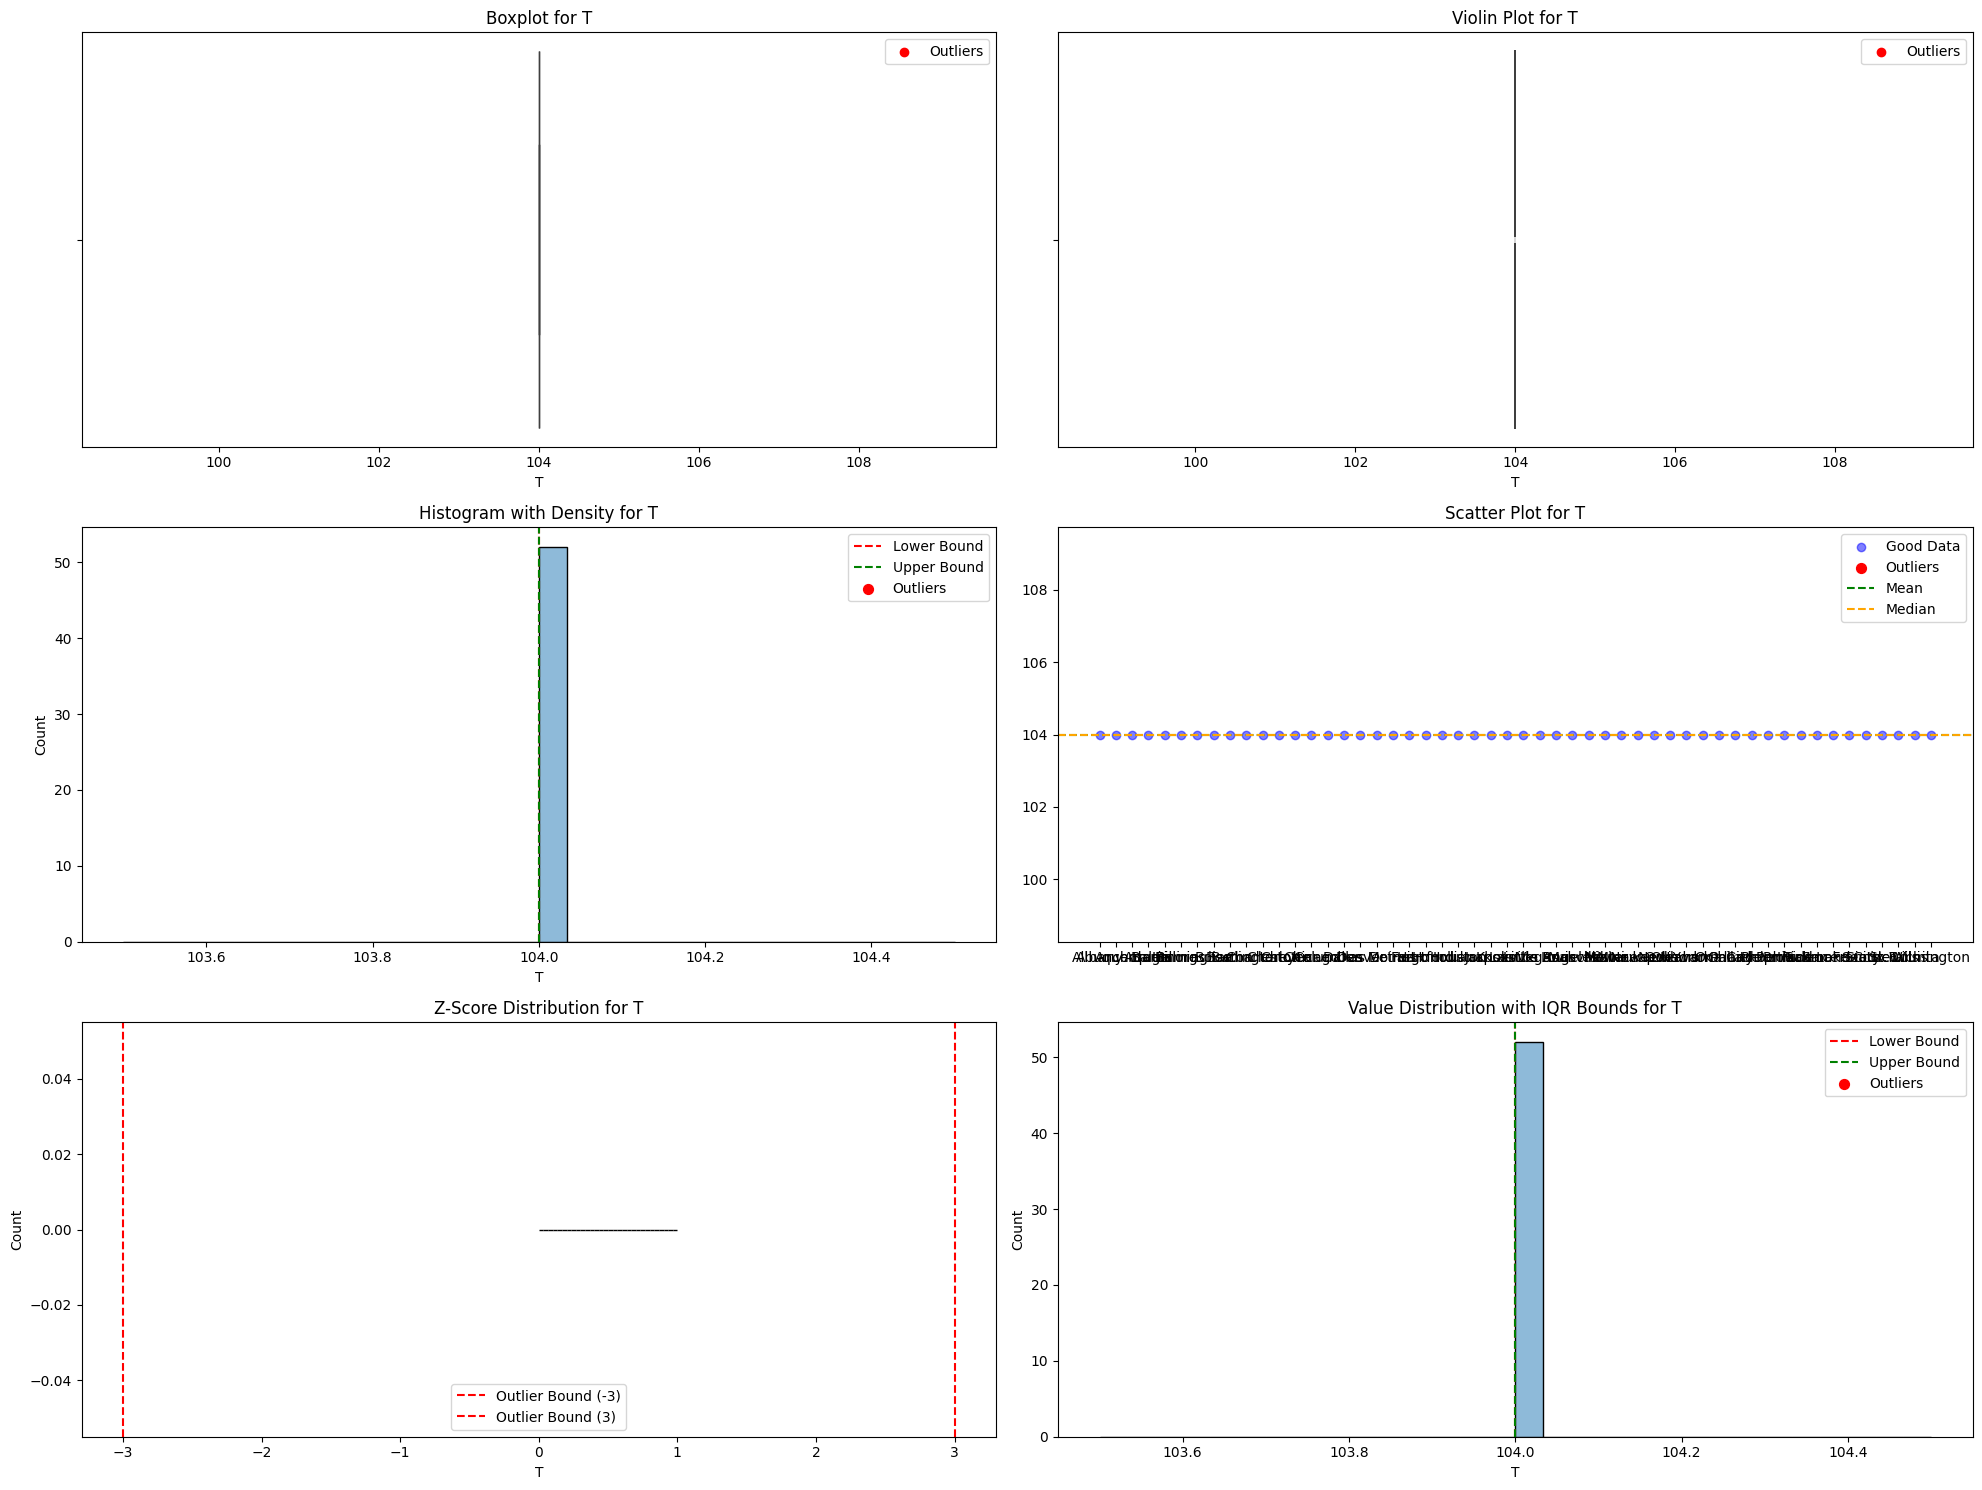

No outliers detected.
Result: Good (No outliers)
No outliers in T (Result: Good)


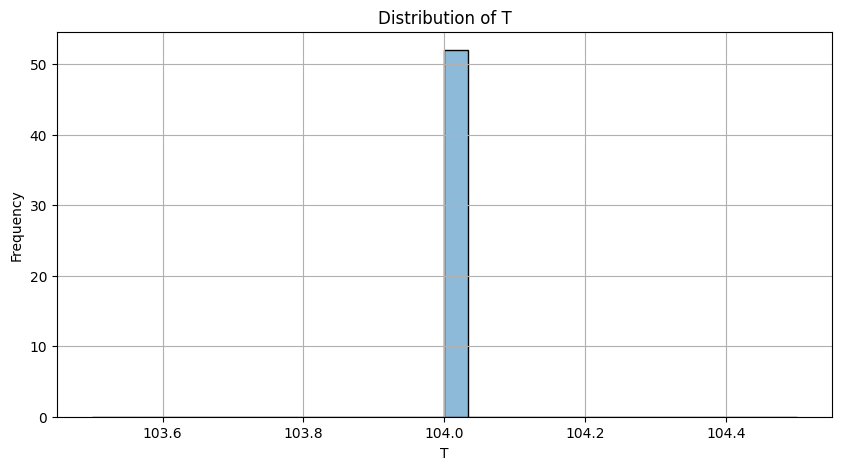

Skewness:
 T    0.0
dtype: float64

Kurtosis:
 T    0.0
dtype: float64
T - Skewness: 0.0000 (Normal), Kurtosis: 0.0000 (Normal)

Checking column: monetary_value (Type: float64)
Running checks for numerical data...
Statistical Summary:
        monetary_value
count       52.000000
mean     60269.819862
std      29371.118511
min      23456.523438
25%      36724.816406
50%      55635.447266
75%      79089.763672
max     150069.140625


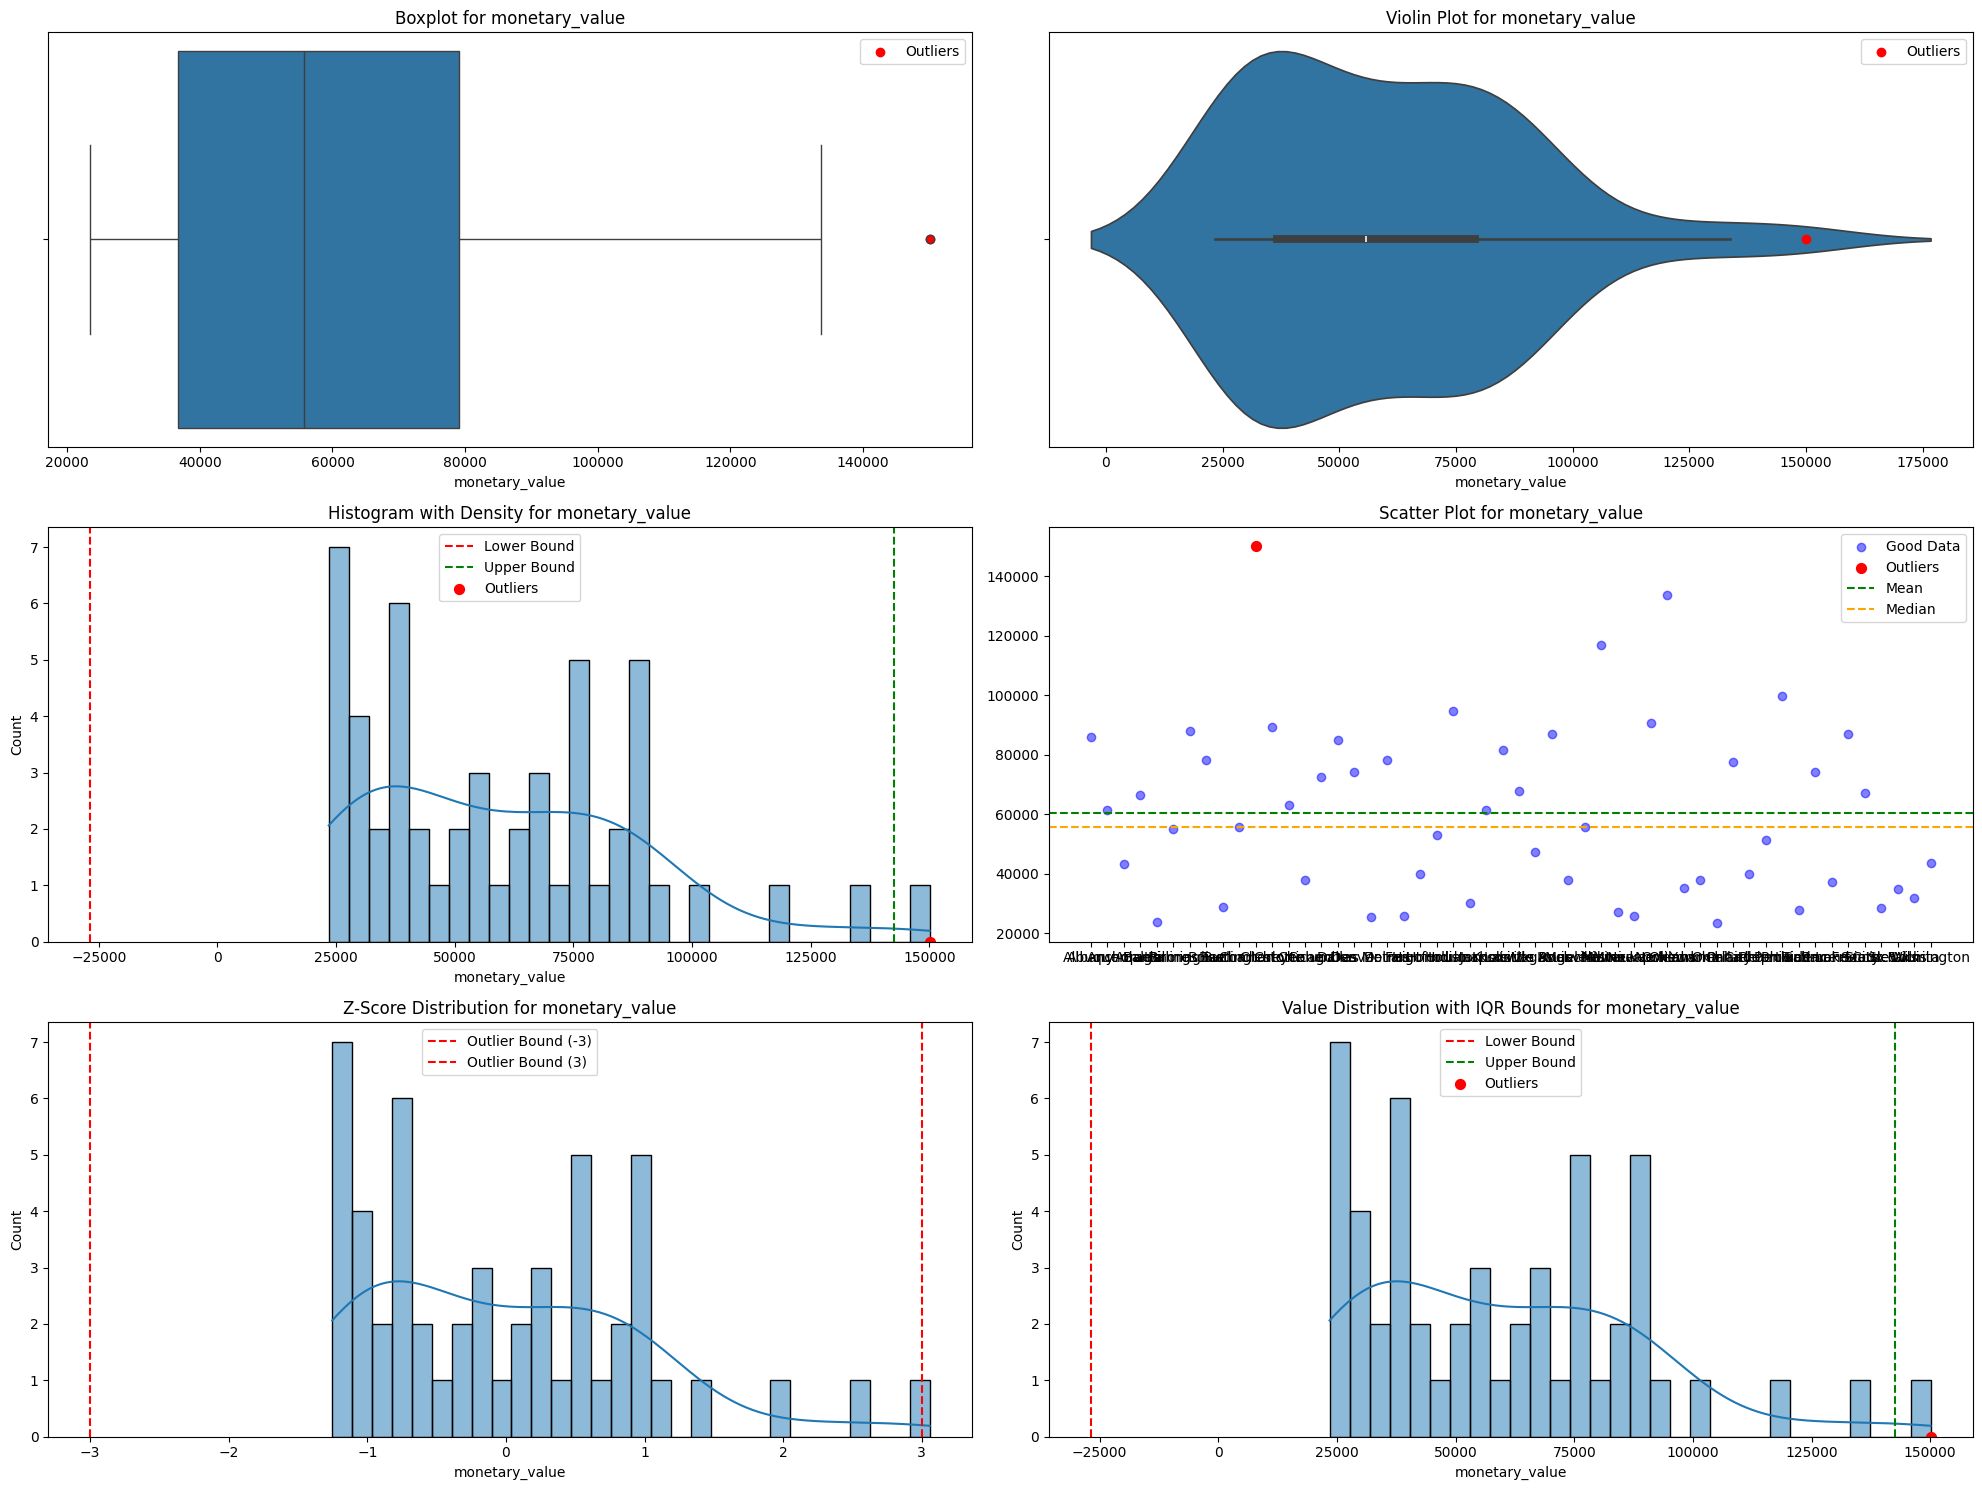

Outliers detected in column monetary_value:
            monetary_value
City                      
Charleston   150069.140625
Result: Bad (Presence of outliers)
Outliers in monetary_value: 1 (Result: Bad)


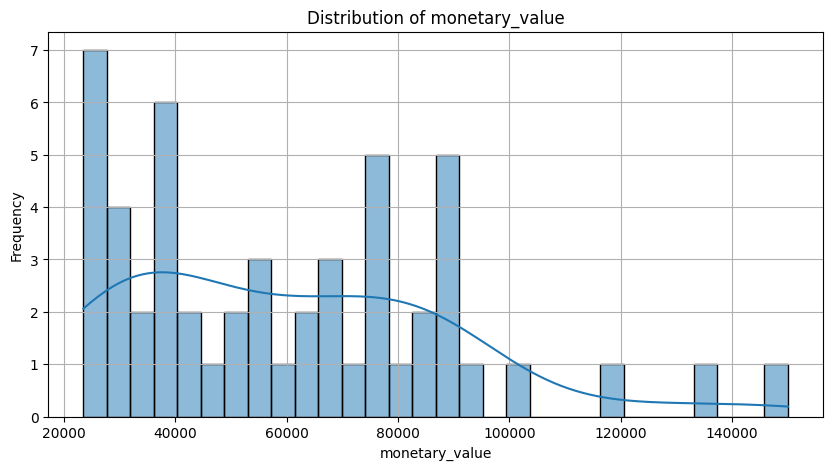

Skewness:
 monetary_value    0.857099
dtype: float64

Kurtosis:
 monetary_value    0.63776
dtype: float64
monetary_value - Skewness: 0.8571 (Skewed), Kurtosis: 0.6378 (Normal)


In [17]:
# Run type-specific checks
run_type_specific_checks(data)

In [18]:
data_f = data#[(data['Frequency'] > 0) & (data['Recency'] <= data['Tenure'])]

## Model training and evaluation

In [19]:
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_history_alive

In [37]:
def evaluate_model(data, r, alpha, a, b):
    """Evaluate the lifetimes model with key metrics and plots."""
    
    # Print model parameters
    print(f"\nBetaGeoFitter Parameters:")
    print(f"r: {r:.2f}")
    print(f"alpha: {alpha:.2f}")
    print(f"a: {a:.2f}")
    print(f"b: {b:.2f}")
    
    # Calculate log likelihood, AIC, and BIC manually
    log_likelihood = np.sum(np.log(beta.pdf(data['frequency'], a, b)))
    aic = -2 * log_likelihood + 2 * 2
    bic = -2 * log_likelihood + 2 * np.log(len(data))
    
    # Print metrics
    print(f"\nBetaGeoFitter Results:")
    print(f"Log-Likelihood: {log_likelihood:.2f}")
    print(f"AIC: {aic:.2f}")
    print(f"BIC: {bic:.2f}")
    
    # Calculate additional metrics
    expected_transactions = r * alpha
    mae = np.mean(np.abs(expected_transactions - data['frequency']))
    mse = np.mean((expected_transactions - data['frequency'])**2)
    print(f"Expected Transactions: {expected_transactions:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    
    # Print metrics
    print(f"\n{model.__class__.__name__} Results:")
    print(f"Log-Likelihood: {log_likelihood:.2f} (Higher values indicate a better fit)")
    print(f"AIC: {aic:.2f} (Lower values indicate a better fit; penalizes complexity)")
    print(f"BIC: {bic:.2f} (Lower values indicate a better fit; heavier penalty for complexity)")

    # Goodness of fit checks
    if log_likelihood > -10:  # Example threshold
        print("Result: Good (Log-Likelihood is high)")
    #else:
        print("Result: Bad (Log-Likelihood is low)")

    if aic < 100:  # Example threshold
        print("Result: Good (AIC is low)")
    else:
        print("Result: Bad (AIC is high)")

    if bic < 100:  # Example threshold
        print("Result: Good (BIC is low)")
    else:
        print("Result: Bad (BIC is high)")

    # Plotting Survival Function
    plt.figure(figsize=(10, 6))
    model.plot_survival_function()
    plt.title(f'{model.__class__.__name__} Survival Function')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.grid()
    plt.show()
    print("Interpretation: The survival function shows the probability that a customer will continue to be active over time. A higher curve indicates better retention, which is a good sign for the model.")

    # Frequency-Recency Matrix
    plt.figure(figsize=(10, 6))
    plot_frequency_recency_matrix(model)
    plt.title('Frequency-Recency Matrix')
    plt.show()
    print("Interpretation: This matrix visualizes the distribution of customers based on their frequency and recency of purchases. A good model will show clear clusters, indicating identifiable customer segments.")

    # Probability Alive Matrix
    plt.figure(figsize=(10, 6))
    plot_probability_alive_matrix(model)
    plt.title('Probability Alive Matrix')
    plt.show()
    print("Interpretation: This matrix represents the probability that customers are still alive (active). A higher proportion in the 'Alive' section is a good indication of customer retention.")

    # Period Transactions
    plt.figure(figsize=(10, 6))
    plot_period_transactions(model)
    plt.title('Period Transactions')
    plt.show()
    print("Interpretation: This plot shows the number of transactions over a specified period. A consistent or increasing trend suggests healthy customer engagement.")

    # Calibration: Purchases vs. Holdout Purchases
    plt.figure(figsize=(10, 6))
    plot_calibration_purchases_vs_holdout_purchases(model)
    plt.title('Calibration: Purchases vs. Holdout Purchases')
    plt.show()
    print("Interpretation: This plot compares the model's predicted purchases against actual holdout purchases. A good fit shows predictions closely aligning with actual values.")

    # History Alive
    plt.figure(figsize=(10, 6))
    plot_history_alive(model)
    plt.title('History Alive')
    plt.show()
    print("Interpretation: This plot shows the history of customer activity over time. A higher count of active customers indicates a successful model.")


In [36]:
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(data_f['frequency'], data_f['recency'], data_f['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 52 subjects, a: 0.00, alpha: 1.64, b: 0.00, r: 1.64>


In [41]:
bgf.params_

r        1.644973e+00
alpha    1.644922e+00
a        4.285139e-18
b        6.873665e-06
dtype: float64

In [28]:
evaluate_model(data_f,list(bgf.params_))

TypeError: fit() missing 1 required positional argument: 'recency'

Text(0.5, 0, 'City historical Frequency')

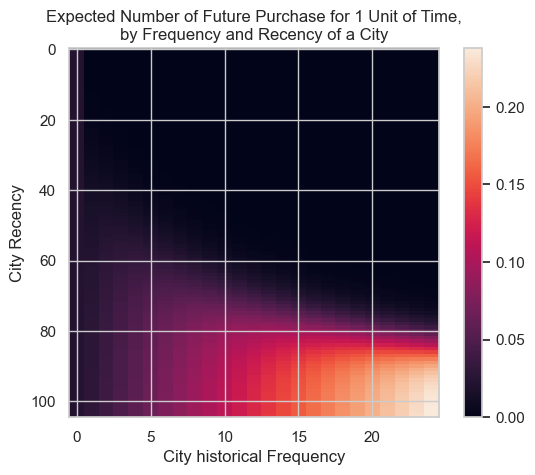

In [370]:
plot_frequency_recency_matrix(bgf)
plt.title('Expected Number of Future Purchase for 1 Unit of Time,\nby Frequency and Recency of a City')
plt.ylabel('City Recency')
plt.xlabel('City historical Frequency')

Text(0.5, 0, 'City historical Frequency')

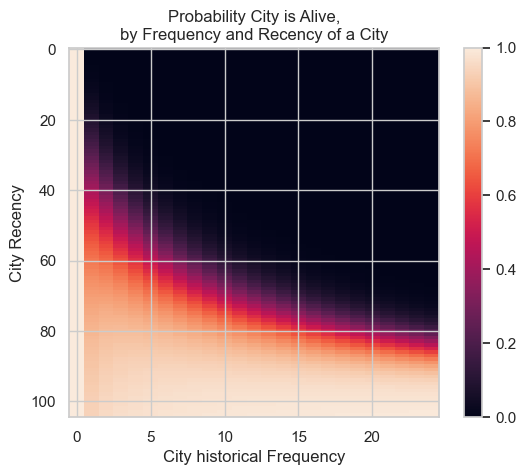

In [371]:
plot_probability_alive_matrix(bgf)
plt.title('Probability City is Alive,\nby Frequency and Recency of a City')
plt.ylabel('City Recency')
plt.xlabel('City historical Frequency')

In [396]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data_f['frequency'], data_f['recency'], data_f['T'])
data.sort_values(by='predicted_purchases').tail(5)

frequency  recency     T  monetary_value  predicted_purchases
City                                                                     
Richmond         12.0     48.0  49.0   601095.690000             0.256997
Louisville       12.0     48.0  49.0   296950.713333             0.256997
Anchorage        13.0     50.0  51.0   328139.205385             0.265408
Portland         21.0     51.0  51.0   505781.122381             0.404982
Charleston       24.0     49.0  51.0   625112.039167             0.452792

<AxesSubplot: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

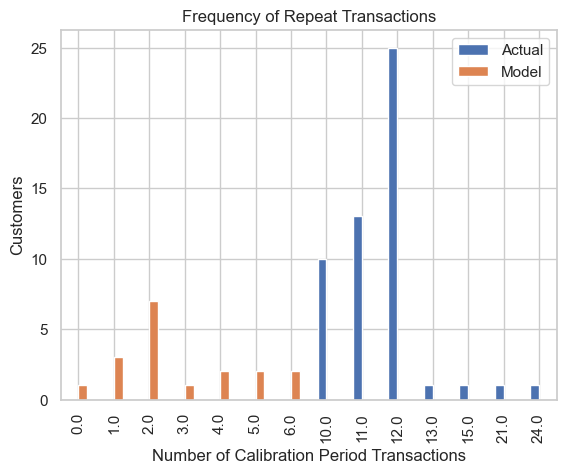

In [397]:
plot_period_transactions(bgf)

In [398]:
data_cal_holdout = calibration_and_holdout_data(start_data, 'City', 'Invoice Date',
                                        calibration_period_end='2021-06-01',
                                        observation_period_end='2021-12-31' ,freq='W')
print(data_cal_holdout.head())

             frequency_cal  recency_cal  T_cal  frequency_holdout  \
City                                                                
Albany                 4.0         16.0   20.0                7.0   
Albuquerque            5.0         19.0   20.0                7.0   
Anchorage              6.0         19.0   21.0                7.0   
Atlanta                5.0         18.0   21.0                7.0   
Baltimore              5.0         18.0   20.0                7.0   

             duration_holdout  
City                           
Albany                   30.0  
Albuquerque              30.0  
Anchorage                30.0  
Atlanta                  30.0  
Baltimore                30.0  


In [399]:
bgf.fit(data_cal_holdout['frequency_cal'], data_cal_holdout['recency_cal'], data_cal_holdout['T_cal'])
bgf.save_model('../models/bgf_small_size.pkl', save_data=False, save_generate_data_method=False)

<AxesSubplot: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

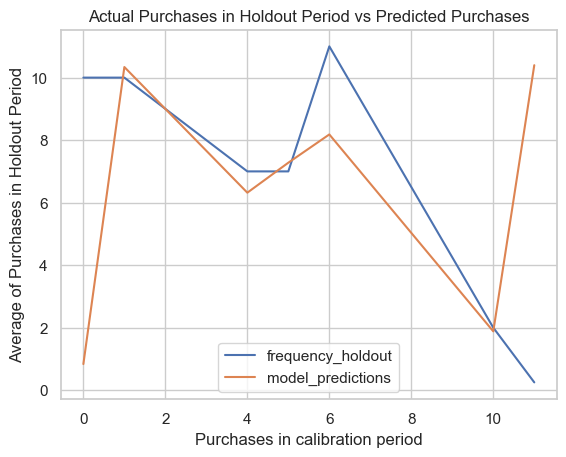

In [400]:
plot_calibration_purchases_vs_holdout_purchases(bgf, data_cal_holdout)

In [377]:
t = 10 #predict purchases in 10 periods
individual = data.iloc[2]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])


2.5928165575686286

In [378]:
data_cal_holdout.index

Index(['Albany', 'Albuquerque', 'Anchorage', 'Atlanta', 'Baltimore',
       'Billings', 'Boise', 'Boston', 'Burlington', 'Charleston', 'Charlotte',
       'Cheyenne', 'Columbus', 'Denver', 'Des Moines', 'Detroit', 'Fargo',
       'Hartford', 'Honolulu', 'Houston', 'Indianapolis', 'Jackson',
       'Knoxville', 'Las Vegas', 'Little Rock', 'Los Angeles', 'Louisville',
       'Manchester', 'Miami', 'Milwaukee', 'Minneapolis', 'New Orleans',
       'New York', 'Newark', 'Oklahoma City', 'Omaha', 'Orlando',
       'Philadelphia', 'Phoenix', 'Portland', 'Providence', 'Richmond',
       'Salt Lake City', 'San Francisco', 'Seattle', 'Sioux Falls',
       'St. Louis', 'Wichita', 'Wilmington'],
      dtype='object', name='City')

<AxesSubplot: title={'center': 'History of P_alive'}, ylabel='P_alive'>

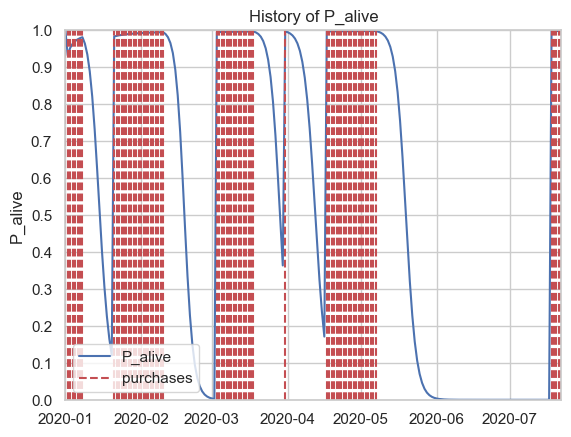

In [407]:
id = 'New York'
days_since_birth = 30
sp_trans = start_data.loc[start_data['City'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'Invoice Date')

In [380]:
data_returning = data[data.frequency > 0]


In [381]:
data_returning[['monetary_value', 'frequency']].corr()

monetary_value  frequency
monetary_value        1.000000  -0.014673
frequency            -0.014673   1.000000

In [382]:
from lifetimes import GammaGammaFitter


In [383]:
ggf = GammaGammaFitter(penalizer_coef = 0.01)
ggf.fit(data_returning['frequency'],
        data_returning['monetary_value'])
print(ggf)
ggf.save_model('../models/ggf_small_size.pkl', save_data=False, save_generate_data_method=False)

<lifetimes.GammaGammaFitter: fitted with 52 subjects, p: 2.14, q: 0.09, v: 2.12>


In [384]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

City
Albany         844125.774562
Albuquerque    552642.461205
Anchorage      339227.883184
Atlanta        529162.681044
Baltimore      214314.922073
Billings       627183.811867
Birmingham     923975.439692
Boise          675632.353041
Boston         258672.525789
Burlington     469641.813041
dtype: float64


In [391]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).mean(),
    data[data['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 530324.7416177763, Average profit: 510719.8073623332


In [392]:

bgf.fit(data['frequency'], data['recency'], data['T'])


<lifetimes.BetaGeoFitter: fitted with 52 subjects, a: 0.15, alpha: 6.63, b: 2.25, r: 2.53>

In [387]:
print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future purchases
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=2, # weekly
    discount_rate=0.00 # Weekly discount rate 
).tail(20))


City
Milwaukee         3.053059e+06
Minneapolis       3.904379e+00
New Orleans       1.092679e+07
New York          2.068954e+00
Newark            4.076004e+06
Oklahoma City     4.800236e+06
Omaha             1.158058e+04
Orlando           9.877331e+06
Philadelphia      2.585653e+06
Phoenix           6.416206e+06
Portland          1.180372e+07
Providence        3.497337e+06
Richmond          9.014252e+06
Salt Lake City    4.476728e+06
San Francisco     1.227761e+03
Seattle           2.926387e-01
Sioux Falls       3.353626e+06
St. Louis         4.444191e+06
Wichita           4.075756e+06
Wilmington        5.200145e+06
Name: clv, dtype: float64


## Monitoring

### Data drift

### Model drift
